<a id="top_section"></a>
<div align='center'><font size="5" color="#000000"><b>Projet 7. Implémentez un modèle de scoring</b></font></div>
<hr>
<div align='center'><font size="3" color="#000000">Notebook de modélisation</font></div>
<hr>

La première mission proposée dans le cadre du projet 7 de la formation Data Scientist d'OpenClassrooms consiste à remplir ces quatre objectifs : 

1. Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique. Puis classifier la demande en crédit accordé ou refusé. S’appuyer sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.)
2. Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.
3. Mettre en production le modèle de scoring de prédiction à l’aide d’une API et réaliser une interface de test de cette API.
4. Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l’analyse en production du data drift.

## Importation des Packages

In [1]:
# Imports principaux
import numpy as np
import pandas as pd 
from collections import Counter

# Prétraitement des données
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SMOTE

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# MLflow
import mlflow
import mlflow.sklearn

# Modélisation
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
import shap

## Chargement des données

In [2]:
df = pd.read_csv('projet7_data.csv')
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CRED_NAME_CONTRACT_STATUS_Signed_MAX,CRED_NAME_CONTRACT_STATUS_Signed_MEAN,CRED_NAME_CONTRACT_STATUS_Signed_SUM,CRED_NAME_CONTRACT_STATUS_Signed_VAR,CRED_NAME_CONTRACT_STATUS_nan_MIN,CRED_NAME_CONTRACT_STATUS_nan_MAX,CRED_NAME_CONTRACT_STATUS_nan_MEAN,CRED_NAME_CONTRACT_STATUS_nan_SUM,CRED_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Préparation des données

### Gestion des valeurs manquantes

In [3]:
def missing_values_table(df):
    """
    Calcule les valeurs manquantes pour chaque colonne d'un DataFrame et retourne un tableau résumant les résultats.

    Parameters:
    df (pandas.DataFrame): Le DataFrame pour lequel les valeurs manquantes doivent être calculées.

    Returns:
    pandas.DataFrame: Un tableau résumant le nombre et le pourcentage de valeurs manquantes pour chaque colonne du DataFrame.
    """
    # Nombre total de valeurs manquantes par colonne
    mis_val = df.isnull().sum()
    
    # Pourcentage de valeurs manquantes par colonne
    mis_val_percent = 100 * mis_val / len(df)
    
    # Création d'un tableau avec les résultats
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Renommer les colonnes du tableau
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Nombre de valeurs manquantes', 1: 'Pourcentage de valeurs manquantes'})
    
    # Trier le tableau par pourcentage de valeurs manquantes de manière décroissante
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            'Pourcentage de valeurs manquantes', ascending=False).round(1)
    
    # Afficher des informations résumées
    print ("Le DataFrame sélectionné comporte " + str(df.shape[1]) + " colonnes,\n"      
            "parmis lesquelles " + str(mis_val_table_ren_columns.shape[0]) +
            " contiennent des valeurs manquantes.")
    
    # Retourner le DataFrame contenant les informations sur les valeurs manquantes
    return mis_val_table_ren_columns

In [4]:
missing_values = missing_values_table(df)
missing_values.head(20)

Le DataFrame sélectionné comporte 696 colonnes,
parmis lesquelles 502 contiennent des valeurs manquantes.


,Nombre de valeurs manquantes,Pourcentage de valeurs manquantes
CRED_AMT_PAYMENT_CURRENT_VAR,246888,80.3
CRED_CNT_DRAWINGS_OTHER_CURRENT_VAR,246814,80.3
CRED_AMT_DRAWINGS_POS_CURRENT_VAR,246814,80.3
CRED_AMT_DRAWINGS_ATM_CURRENT_VAR,246814,80.3
CRED_CNT_DRAWINGS_POS_CURRENT_VAR,246814,80.3
CRED_AMT_DRAWINGS_OTHER_CURRENT_VAR,246814,80.3
CRED_CNT_DRAWINGS_ATM_CURRENT_VAR,246814,80.3
CRED_AMT_PAYMENT_CURRENT_MIN,246447,80.1
CRED_AMT_PAYMENT_CURRENT_MEAN,246447,80.1
CRED_AMT_PAYMENT_CURRENT_MAX,246447,80.1


On peut observer que la proportion de valeurs manquantes est très importante pour certaines variables. En revanche,  la plupart des modèles de machine learning n'acceptent pas directement des données contenant des valeurs manquantes. Nous allons donc supprimer les variables qui ont moins de 75% de valeurs non manquantes :

In [5]:
tmp = df.shape[1]
df = df.dropna(axis=1, thresh=int(0.75 * df.shape[0]))
print('Nombre de variables supprimées :', tmp-df.shape[1])

Nombre de variables supprimées : 203


Nous allons maintenant supprimer les observations qui ont moins de 75% de valeurs non manquantes :

In [6]:
tmp = df.shape[0]
df = df.dropna(thresh=int(0.75 * df.shape[1]))
print("Nombre d'observations supprimées :", tmp-df.shape[0])

Nombre d'observations supprimées : 16454


In [7]:
missing_values = missing_values_table(df)
missing_values.head(20)

Le DataFrame sélectionné comporte 493 colonnes,
parmis lesquelles 124 contiennent des valeurs manquantes.


,Nombre de valeurs manquantes,Pourcentage de valeurs manquantes
BUR_AMT_CREDIT_SUM_LIMIT_MEAN,61006,21.0
EXT_SOURCE_3,57188,19.6
DAYS_EMPLOYED,52589,18.1
DAYS_EMPLOYED_PERC,52589,18.1
BUR_AMT_CREDIT_SUM_DEBT_MEAN,48286,16.6
BUR_AMT_CREDIT_SUM_DEBT_MAX,48286,16.6
BUR_DAYS_CREDIT_ENDDATE_MIN,43626,15.0
BUR_DAYS_CREDIT_ENDDATE_MAX,43626,15.0
BUR_DAYS_CREDIT_ENDDATE_MEAN,43626,15.0
BUR_AMT_CREDIT_SUM_MEAN,41551,14.3


Nous allons maintenant imputer les valeurs manquantes par la médiane des valeurs observées de chaque variable :

In [8]:
# Remplacer les valeurs infinies par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [9]:
# Initialiser l'imputer
imputer = SimpleImputer(strategy='median')

# Imputer les valeurs manquantes
df_imputed = imputer.fit_transform(df)

In [10]:
# Convertir le résultat en DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

In [11]:
df_imputed.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INST_AMT_INSTALMENT_MEAN,INST_AMT_INSTALMENT_SUM,INST_AMT_PAYMENT_MIN,INST_AMT_PAYMENT_MAX,INST_AMT_PAYMENT_MEAN,INST_AMT_PAYMENT_SUM,INST_DAYS_ENTRY_PAYMENT_MAX,INST_DAYS_ENTRY_PAYMENT_MEAN,INST_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002.0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,100003.0,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,100004.0,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,100006.0,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,100007.0,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0


In [12]:
# Vérification du nombre de colonnes contenant des valeurs manquantes
missing_values = missing_values_table(df_imputed)
missing_values.head(20)

Le DataFrame sélectionné comporte 493 colonnes,
parmis lesquelles 0 contiennent des valeurs manquantes.


,Nombre de valeurs manquantes,Pourcentage de valeurs manquantes


Le jeu de données ne contient plus de valeurs manquantes.

### Séparation de la variable cible des variables prédictives

In [13]:
y = df_imputed['TARGET']
print(y)

0         1.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
291048    0.0
291049    0.0
291050    0.0
291051    1.0
291052    0.0
Name: TARGET, Length: 291053, dtype: float64


In [14]:
X = df_imputed.drop(columns=['SK_ID_CURR', 'TARGET'])
X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,INST_AMT_INSTALMENT_MEAN,INST_AMT_INSTALMENT_SUM,INST_AMT_PAYMENT_MIN,INST_AMT_PAYMENT_MAX,INST_AMT_PAYMENT_MEAN,INST_AMT_PAYMENT_SUM,INST_DAYS_ENTRY_PAYMENT_MAX,INST_DAYS_ENTRY_PAYMENT_MEAN,INST_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,52.180822,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,52.068493,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,54.608219,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0


### Transformations mathématiques des variables prédictives
#### Transformation logarithmique

Le jeu de données contient des variables dont la distribution est très asymétrique. Pour les identifier, nous allons utiliser la mesure de skewness et sélectionner uniquement celles qui contiennent plus de trois valeurs uniques :

In [15]:
def identify_skewed_features(data, threshold=100):
    """
    Identifie les variables présentant une forte asymétrie (skewness) dans un DataFrame.

    Cette fonction calcule la skewness de chaque variable dans le DataFrame, puis filtre les variables
    ayant une skewness absolue supérieure au seuil spécifié. Elle exclut également les variables qui ont 
    moins de 3 valeurs uniques.

    Parameters:
    data (pandas.DataFrame): Le DataFrame contenant les variables à analyser.
    threshold (int): Le seuil pour considérer une skewness comme "forte". Les variables avec une skewness
                     absolue supérieure à ce seuil seront identifiées comme étant skewed. Par défaut, 
                     la valeur est fixée à 100.

    Returns:
    list: Une liste contenant les noms des variables présentant une forte asymétrie.
    """
    # Calculer la skewness de chaque variable
    skewness = data.apply(lambda x: x.skew()).sort_values(ascending=False)
    
    # Filtrer les variables avec une skewness absolue supérieure au seuil
    skewed_features = skewness[abs(skewness) > threshold].index
    
    # Filtrer les variables avec plus de 2 valeurs uniques
    skewed_features = [feature for feature in skewed_features if data[feature].nunique() > 3]
    
    return skewed_features

# Identifier les features avec une forte asymétrie
skewed_features = identify_skewed_features(X)

Affichage des boîtes à moustache de ces variables :

In [16]:
def boxplot_variable(dataframe):
    """
    Crée des boîtes à moustaches pour visualiser la distribution des valeurs numériques dans un DataFrame.

    Args:
    - dataframe (pandas.DataFrame ou pandas.Series): Le DataFrame contenant les données à visualiser.
        Si un pandas.Series est fourni, un seul diagramme de boîte est tracé pour cette série.

    Returns:
    - None
    """

    # Vérifie si l'entrée est une pandas.Series
    if isinstance(dataframe, pd.core.series.Series):
        # Crée un diagramme de boîte pour la série
        plt.figure(figsize=(10, 1))
        plt.boxplot(dataframe.dropna(), vert=False)  # Trace le diagramme de boîte horizontal
        plt.ylim([0.9, 1.1])  # Définit les limites de l'axe y
        plt.show()

    else:
        # Parcours toutes les colonnes numériques du DataFrame
        for col in dataframe.select_dtypes(include=['number']).columns:
            # Crée un diagramme de boîte pour chaque colonne numérique
            plt.figure(figsize=(10, 1))
            plt.boxplot(dataframe[col].dropna(), vert=False)  # Trace le diagramme de boîte horizontal
            plt.ylim([0.9, 1.1])  # Définit les limites de l'axe y
            plt.xlabel(col)  # Définit le nom de l'axe x
            plt.title(f'Variable : {col}')  # Définit le titre du graphique
            plt.show()

AMT_INCOME_TOTAL


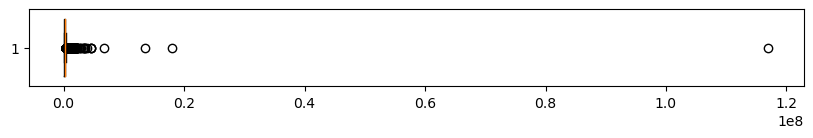

PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN


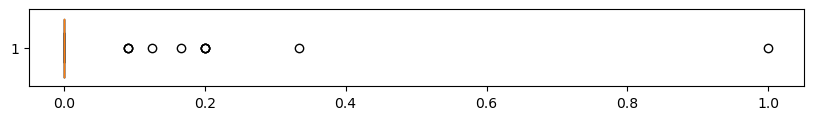

POS_NAME_CONTRACT_STATUS_Canceled_MEAN


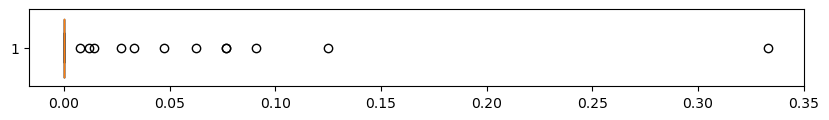

BUR_CREDIT_TYPE_Loan for the purchase of equipment_MEAN


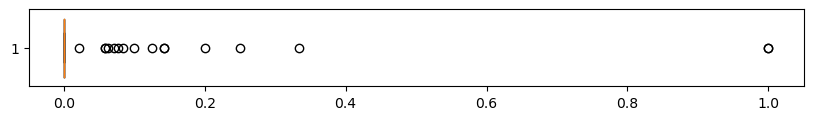

PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN


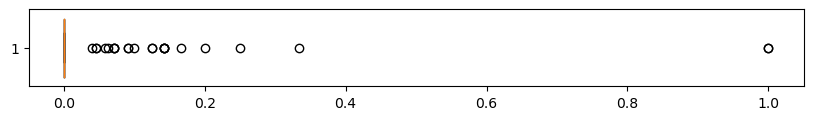

BUR_CREDIT_TYPE_Real estate loan_MEAN


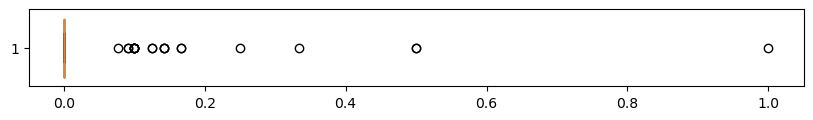

BUR_CREDIT_CURRENCY_currency 4_MEAN


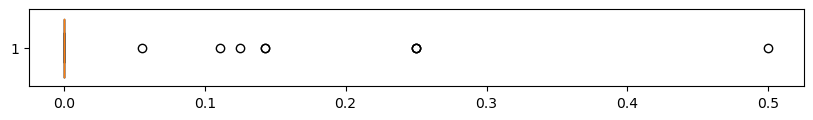

BUR_AMT_CREDIT_SUM_OVERDUE_MEAN


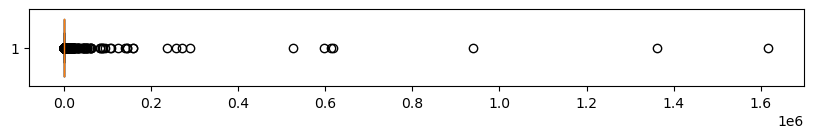

INST_PAYMENT_PERC_VAR


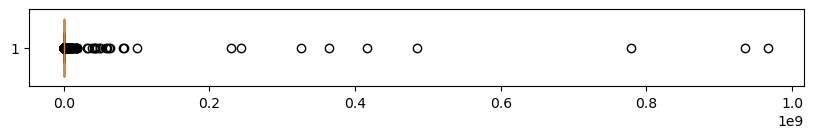

INCOME_CREDIT_PERC


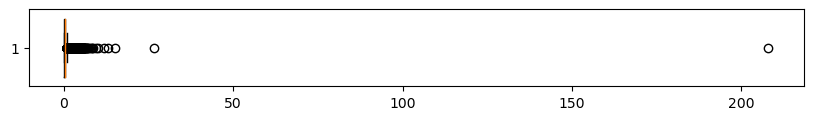

INCOME_PER_PERSON


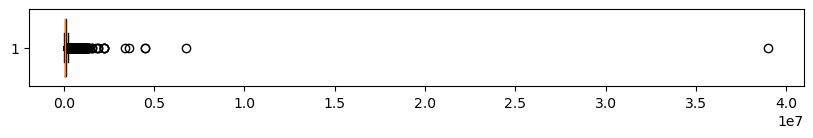

BUR_CREDIT_ACTIVE_Bad debt_MEAN


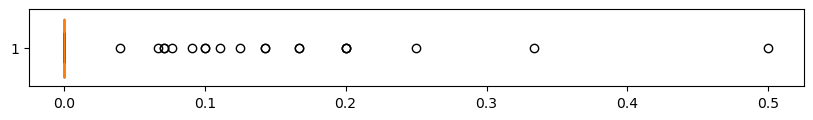

BUR_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN


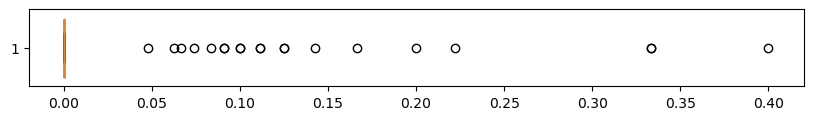

PREV_NAME_GOODS_CATEGORY_Insurance_MEAN


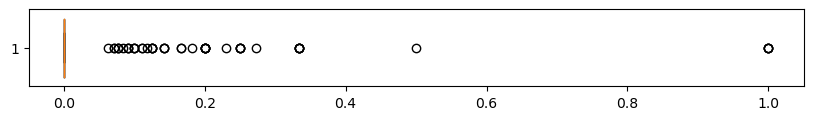

POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN


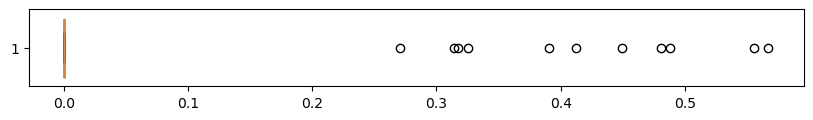

INST_PAYMENT_PERC_MEAN


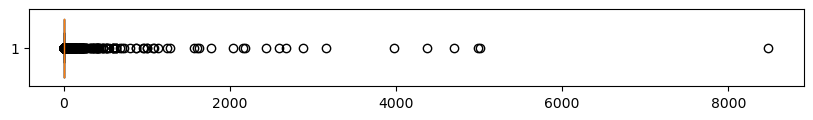

INST_PAYMENT_PERC_MAX


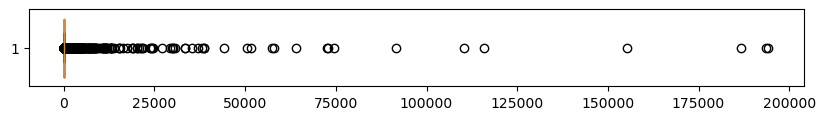

INST_PAYMENT_PERC_SUM


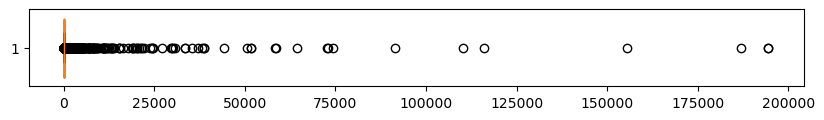

PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN


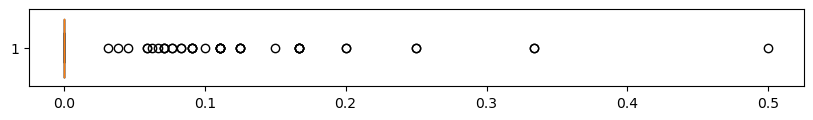

AMT_REQ_CREDIT_BUREAU_QRT


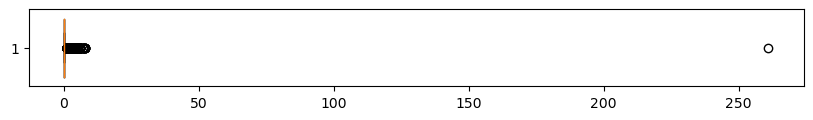

BUR_CREDIT_CURRENCY_currency 3_MEAN


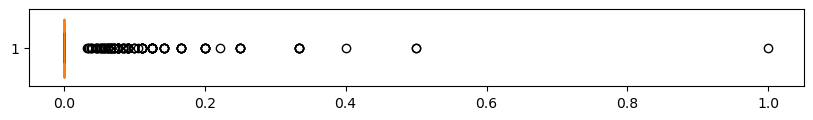

PREV_NAME_GOODS_CATEGORY_Weapon_MEAN


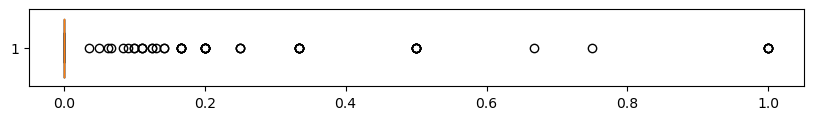

PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN


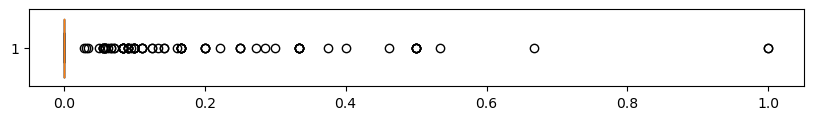

POS_SK_DPD_DEF_MEAN


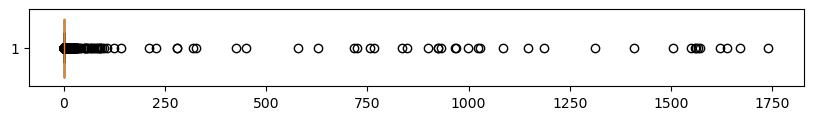

INST_DPD_SUM


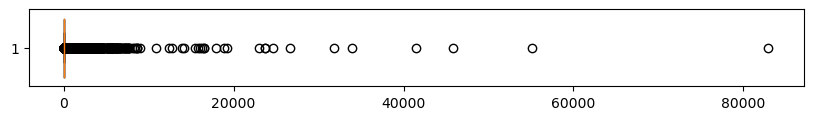

PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN


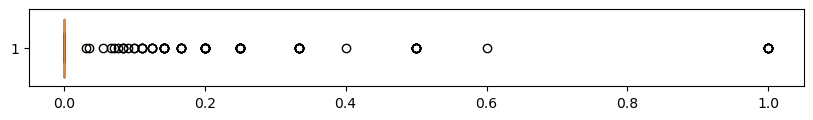

In [17]:
for var in skewed_features:
    print(var)
    boxplot_variable(X[var])

Nous allons maintenant appliquer une transformation logarithmique afin d'homogénéiser leur distribution :

In [18]:
# Transformation logarithmique en utilisant np.log1p pour éviter les valeurs nulles
X[skewed_features] = np.log1p(X[skewed_features])

Vérification :

AMT_INCOME_TOTAL


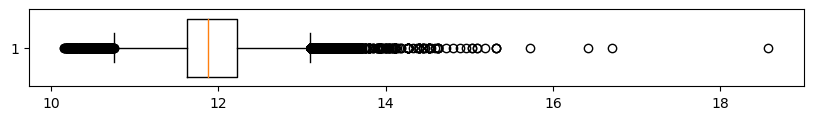

PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN


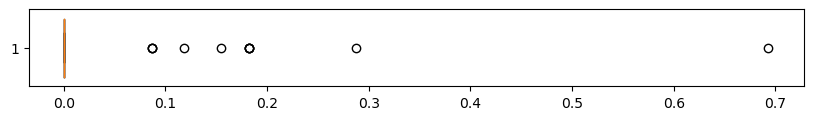

POS_NAME_CONTRACT_STATUS_Canceled_MEAN


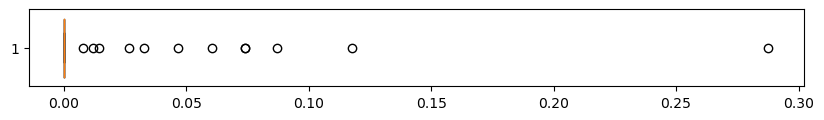

BUR_CREDIT_TYPE_Loan for the purchase of equipment_MEAN


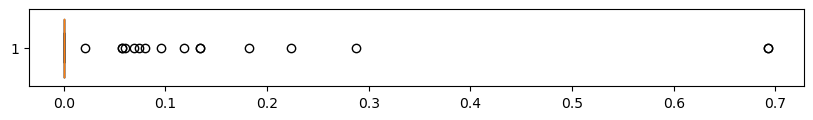

PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN


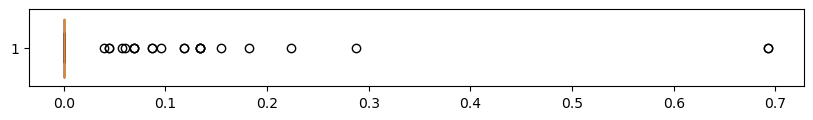

BUR_CREDIT_TYPE_Real estate loan_MEAN


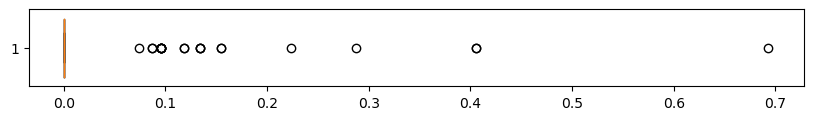

BUR_CREDIT_CURRENCY_currency 4_MEAN


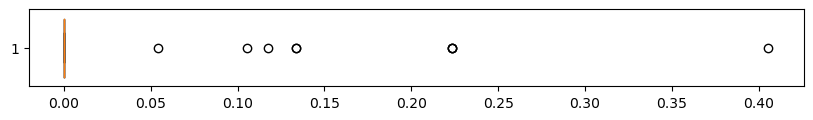

BUR_AMT_CREDIT_SUM_OVERDUE_MEAN


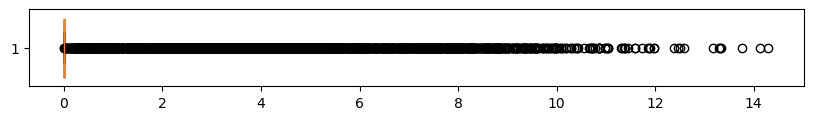

INST_PAYMENT_PERC_VAR


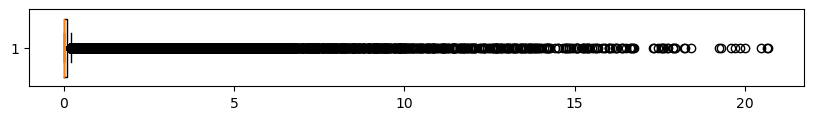

INCOME_CREDIT_PERC


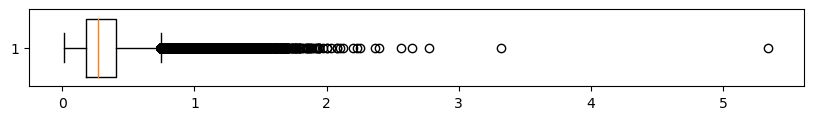

INCOME_PER_PERSON


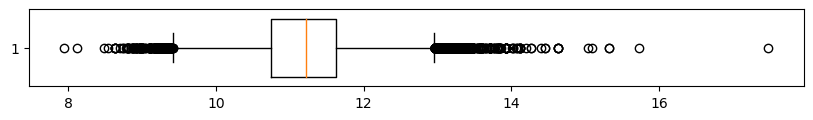

BUR_CREDIT_ACTIVE_Bad debt_MEAN


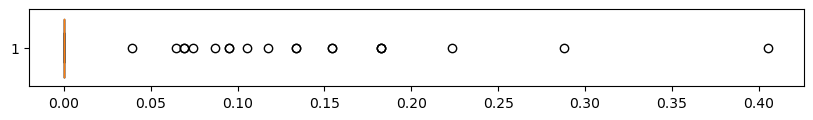

BUR_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN


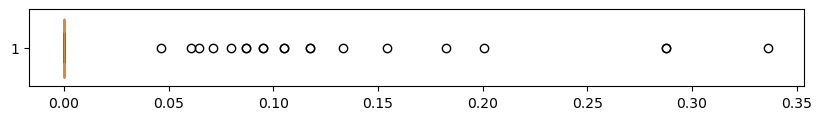

PREV_NAME_GOODS_CATEGORY_Insurance_MEAN


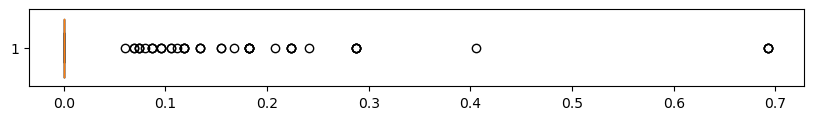

POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN


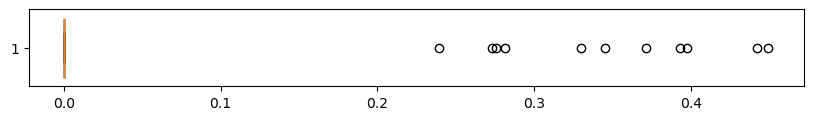

INST_PAYMENT_PERC_MEAN


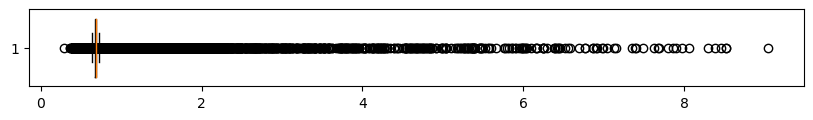

INST_PAYMENT_PERC_MAX


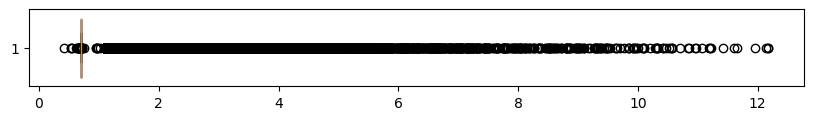

INST_PAYMENT_PERC_SUM


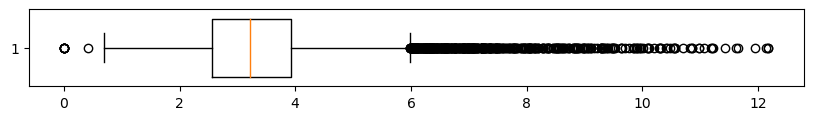

PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN


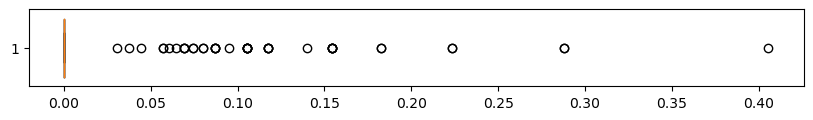

AMT_REQ_CREDIT_BUREAU_QRT


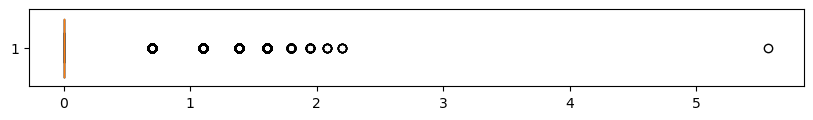

BUR_CREDIT_CURRENCY_currency 3_MEAN


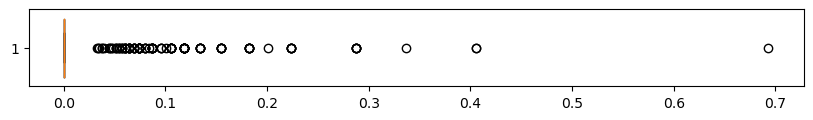

PREV_NAME_GOODS_CATEGORY_Weapon_MEAN


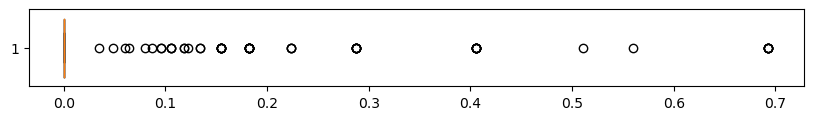

PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN


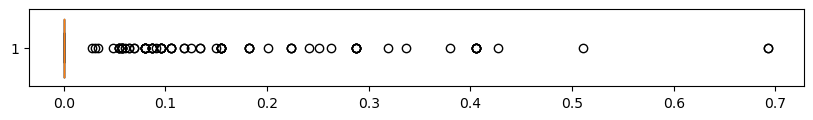

POS_SK_DPD_DEF_MEAN


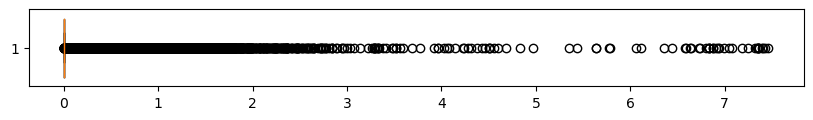

INST_DPD_SUM


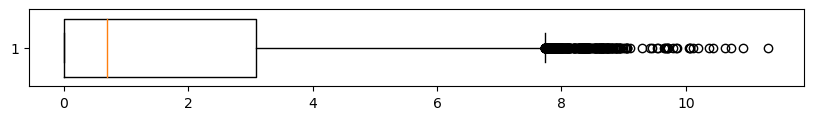

PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN


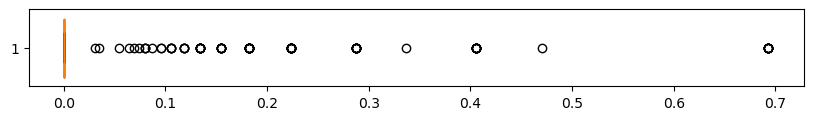

In [19]:
for var in skewed_features:
    print(var)
    boxplot_variable(X[var])

La distribution de ces variables est plus homogène.

#### Normalisation

Certains algorithmes de Machine Learning tels que la régression linéaire sont sensibles à l'amplitude de valeurs des variables : celles dont les valeurs sont plus grandes dominent le processus d'apprentissage.

On va donc normaliser les variables pour qu'elles aient des amplitudes similaires :

In [20]:
# Instanciation du Scaler
scaler = MinMaxScaler()

# Application du Scaler
X_scaled = scaler.fit_transform(X)

# Transformation en Dataframe
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Vérification que les min et max des variables sont tous 0 et 1
X_scaled.describe().loc[['min','max']]

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,INST_AMT_INSTALMENT_MEAN,INST_AMT_INSTALMENT_SUM,INST_AMT_PAYMENT_MIN,INST_AMT_PAYMENT_MAX,INST_AMT_PAYMENT_MEAN,INST_AMT_PAYMENT_SUM,INST_DAYS_ENTRY_PAYMENT_MAX,INST_DAYS_ENTRY_PAYMENT_MEAN,INST_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Suppression des variables composées d'une valeur unique

Le jeu de données contient des variables composées d'une seule variable unique. Nous allons les supprimer car elles n'aideront pas à dinstingues les différentes classes entre elles étant donné qu'elles sont identiques pour toutes les observations.

In [21]:
tmp = X_scaled.shape[1]
X_scaled = X_scaled.loc[:, X_scaled.nunique() > 1]
print('Nombre de variables supprimées :', tmp - X_scaled.shape[1])

Nombre de variables supprimées : 29


### Vérification de problème de data leakage
Nous allons vérifier si le jeu de données ne contient pas de variables trop corrélées à notre variable cible et inconnues à priori dans les données d'entrées du modèle :

In [22]:
data = X_scaled.copy()
data['TARGET'] = y
data

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,INST_AMT_INSTALMENT_SUM,INST_AMT_PAYMENT_MIN,INST_AMT_PAYMENT_MAX,INST_AMT_PAYMENT_MEAN,INST_AMT_PAYMENT_SUM,INST_DAYS_ENTRY_PAYMENT_MAX,INST_DAYS_ENTRY_PAYMENT_MEAN,INST_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT,TARGET
0,0.0,0.0,0.0,0.0,0.245232,0.090287,0.103342,0.077441,0.256321,0.111337,...,0.009436,3.693928e-03,0.014069,0.004609,0.008600,0.984365,0.898168,0.990053,0.048518,1.0
1,1.0,0.0,1.0,0.0,0.279376,0.311736,0.152575,0.271605,0.045016,0.523713,...,0.069555,2.660304e-03,0.148697,0.025848,0.063393,0.823127,0.549439,0.942518,0.064690,0.0
2,0.0,1.0,0.0,0.0,0.114839,0.022472,0.022985,0.023569,0.134897,0.652495,...,0.000915,2.138973e-03,0.002795,0.002827,0.000834,0.763518,0.752716,0.996207,0.005391,0.0
3,1.0,0.0,0.0,0.0,0.197108,0.066837,0.125662,0.063973,0.107023,0.650181,...,0.043272,9.913480e-04,0.183419,0.025127,0.039439,0.996417,0.912443,0.992787,0.040431,0.0
4,0.0,0.0,0.0,0.0,0.184602,0.116854,0.090651,0.117845,0.392880,0.702518,...,0.035918,7.186806e-08,0.006005,0.004870,0.031567,0.995765,0.664523,0.886924,0.175202,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291048,0.0,0.0,1.0,0.0,0.215404,0.052360,0.116134,0.046016,0.446855,0.103771,...,0.002254,2.637522e-03,0.003390,0.002985,0.002054,0.987948,0.950037,0.998184,0.016173,0.0
291049,1.0,0.0,0.0,0.0,0.122499,0.056067,0.046494,0.046016,0.344429,0.750113,...,0.002596,4.011388e-03,0.002663,0.004014,0.002366,0.242345,0.220719,0.976161,0.013477,0.0
291050,1.0,0.0,0.0,0.0,0.211963,0.157969,0.126972,0.135802,0.065247,0.422143,...,0.002646,1.088801e-05,0.001470,0.001637,0.002256,0.434202,0.222807,0.944524,0.035040,0.0
291051,1.0,0.0,0.0,0.0,0.225164,0.081175,0.083218,0.069585,0.069553,0.252484,...,0.008359,9.168927e-04,0.005047,0.004082,0.007619,0.994463,0.948415,0.994915,0.048518,1.0


In [23]:
# Trouver les corrélations avec la variable cible et trier
correlations = data.corr()['TARGET'].sort_values()

In [24]:
# Affichage des corrélations
print('Corrélations les plus importantes positivement:\n', correlations.tail())
print('\nCorrélations les plus importantes négativement:\n', correlations.head())

Corrélations les plus importantes positivement:
 BUR_DAYS_CREDIT_MIN                       0.069862
BUR_CREDIT_ACTIVE_Active_MEAN             0.070283
PREV_NAME_CONTRACT_STATUS_Refused_MEAN    0.077681
BUR_DAYS_CREDIT_MEAN                      0.083696
TARGET                                    1.000000
Name: TARGET, dtype: float64

Corrélations les plus importantes négativement:
 EXT_SOURCE_2                       -0.159779
EXT_SOURCE_3                       -0.154875
DAYS_BIRTH                         -0.080722
PREV_CODE_REJECT_REASON_XAP_MEAN   -0.073938
BUR_CREDIT_ACTIVE_Closed_MEAN      -0.071944
Name: TARGET, dtype: float64


On peut observer que les variables les plus corrélées positivement à notre cible sont :
- BUR_DAYS_CREDIT_MEAN : Moyenne du nombre de jours avant la demande actuelle où le client a fait une demande de crédit auprès d'autres institutions financières.
- PREV_NAME_CONTRACT_STATUS_Refused_MEAN : Status des demandes précédentes de prêts chez d'autres institutions financières, spécifiquement pour la classe "Refused" (crédits refusés).
- BUR_CREDIT_ACTIVE_Active_MEAN : Statuts des crédits déclarés par d'autres institutions financières, spécifiquement pour la classe "Active" (crédits actifs).

On peut observer que les variables les plus corrélées négativement à notre cible sont :
- EXT_SOURCE_3 : Score normalisé provenant d'une source de données externe.
- EXT_SOURCE_2 : Score normalisé provenant d'une source de données externe.
- DAYS_BIRTH : Age du client au moment de la demande de crédit.


Selon la documentation, les variables commençant par 'EXT_SOURCE' sont des scores normalisés provenant de sources de données externes. Bien que leur signification exacte ne soit pas claire, il est possible qu'elles représentent une évaluation du risque de crédit basée sur des informations provenant de différentes institutions financières. Étant donné que ces variables sont opaques, il n'est pas certain que nous ayons accès aux données nécessaires pour les calculer au moment de la prise de décision de l'octroi du crédit. Pour éviter toute ambiguïté, nous allons les retirer du jeu de données.

Les autres variables semblent être disponibles dès le départ, donc elles ne devraient pas poser de problème de fuite de données (data leakage)

In [25]:
X_scaled = X_scaled.drop(columns=['EXT_SOURCE_2', 'EXT_SOURCE_3'])
X_scaled.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,INST_AMT_INSTALMENT_MEAN,INST_AMT_INSTALMENT_SUM,INST_AMT_PAYMENT_MIN,INST_AMT_PAYMENT_MAX,INST_AMT_PAYMENT_MEAN,INST_AMT_PAYMENT_SUM,INST_DAYS_ENTRY_PAYMENT_MAX,INST_DAYS_ENTRY_PAYMENT_MEAN,INST_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0.0,0.0,0.0,0.0,0.245232,0.090287,0.103342,0.077441,0.256321,0.111337,...,0.004615,0.009436,3.693928e-03,0.014069,0.004609,0.008600,0.984365,0.898168,0.990053,0.048518
1,1.0,0.0,1.0,0.0,0.279376,0.311736,0.152575,0.271605,0.045016,0.523713,...,0.025854,0.069555,2.660304e-03,0.148697,0.025848,0.063393,0.823127,0.549439,0.942518,0.064690
2,0.0,1.0,0.0,0.0,0.114839,0.022472,0.022985,0.023569,0.134897,0.652495,...,0.002833,0.000915,2.138973e-03,0.002795,0.002827,0.000834,0.763518,0.752716,0.996207,0.005391
3,1.0,0.0,0.0,0.0,0.197108,0.066837,0.125662,0.063973,0.107023,0.650181,...,0.025133,0.043272,9.913480e-04,0.183419,0.025127,0.039439,0.996417,0.912443,0.992787,0.040431
4,0.0,0.0,0.0,0.0,0.184602,0.116854,0.090651,0.117845,0.392880,0.702518,...,0.005057,0.035918,7.186806e-08,0.006005,0.004870,0.031567,0.995765,0.664523,0.886924,0.175202


### Equilibrage des classes

<Axes: ylabel='Frequency'>

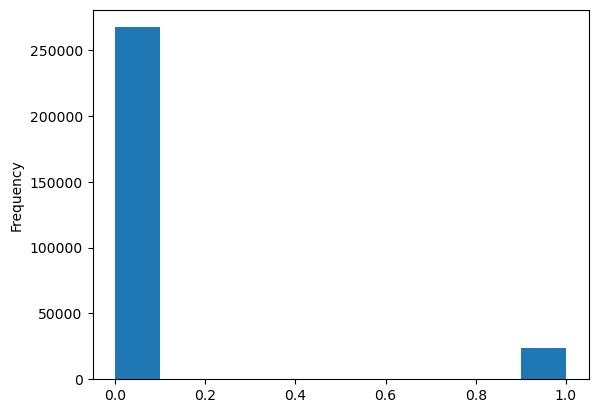

In [26]:
y.astype(int).plot.hist()

Il y a bien plus de prêts qui ont été remboursés à temps (0) que de prêts qui ne l'ont pas été (1). Ces classes sont donc représentées de manière inégale dans le jeu de données. Cependant, cela peut entraîner plusieurs problèmes dans le cadre d'un projet de machine learning :

- Biais du modèle : Un modèle entraîné sur des données déséquilibrées risque de devenir biaisé en faveur de la classe majoritaire.

- Métriques trompeuses : Les mesures de performance comme l'accuracy peuvent être trompeuses. Par exemple, si 95 % des données appartiennent à une seule classe, un modèle qui prédit toujours cette classe aura une précision de 95 %, mais il ne sera pas vraiment efficace pour identifier les exemples de la classe minoritaire.

- Performance réduite : Le modèle peut avoir des difficultés à apprendre les caractéristiques de la classe minoritaire, ce qui conduit à de mauvaises performances pour cette dernière. Dans notre cas, cette classe est très importante car elle nous renseigne sur les prêts non remboursés.

Nous allons donc équilibrer ces classes afin d'éviter ces problèmes. Pour cela, nous allons effectuer un sous-échantillonnage de la classe majoritaire, c'est à dire une réduction du nombre d'observations de la classe majoritaire. 

Une autre technique serait d'effectuer un suréchantillonnage de la classe minoritaire avec SMOTE, c'est à dire augmentation du nombre d'observations de la classe minoritaire de manière synthétique. Cependant, dans le cadre de ce projet, le suréchantillonnage avec SMOTE ne semble pas pertinent, car la classe minoritaire est déjà assez grande, avec un total de 17816 observations. Ce nombre est suffisant pour entraîner et tester efficacement des modèles de machine learning. Nous n'allons donc pas utiliser cette seconde technique car elle risquerait de créer un problème d'overfitting.

In [27]:
print(f'Avant sous-échantillonnage : {Counter(y)}')

# Sous-échantillonnage de la classe majoritaire
under_sampler = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X_scaled, y)
print(f'Après sous-échantillonnage : {Counter(y_resampled)}')

Avant sous-échantillonnage : Counter({0.0: 267208, 1.0: 23845})
Après sous-échantillonnage : Counter({0.0: 23845, 1.0: 23845})


### Réduction du dataset pour diminuer les temps de calcul
Réduction du dataset tout en conservant une représentativité statistique des données originales :

In [28]:
# Concaténer les données pour échantillonnage
data = pd.concat([X_resampled, y_resampled], axis=1)

# Fraction des données à conserver (par exemple 25%)
fraction = 0.25

# Échantillonnage aléatoire
sampled_data = data.sample(frac=fraction, random_state=42)

# Séparer les caractéristiques et les étiquettes
X_sampled = sampled_data.iloc[:, :-1]
y_sampled = sampled_data.iloc[:, -1]

# Vérifier les dimensions
print("Original X_scaled shape:", X_resampled.shape)
print("Original y shape:", y_resampled.shape)
print("Sampled X shape:", X_sampled.shape)
print("Sampled y shape:", y_sampled.shape)

Original X_scaled shape: (47690, 460)
Original y shape: (47690,)
Sampled X shape: (11922, 460)
Sampled y shape: (11922,)


### Séparation des données en ensemble d'entraînement et de test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.25, random_state=42)

## Modélisation

### Définition du score métier

In [30]:
# Définition des coûts des faux positifs et des faux négatifs
cost_fp = 1  # Coût d'un faux positif
cost_fn = 10  # Coût d'un faux négatif

# Fonction pour calculer le score métier
def business_score(y_true, y_pred):
    """
    Calcule le score de performance en utilisant une matrice de confusion.

    Ce score est basé sur les coûts associés aux faux positifs (FP) et aux faux négatifs (FN).
    La fonction renvoie un score négatif car GridSearchCV cherche à maximiser la fonction de score.

    Args:
        y_true (array-like): Valeurs réelles des classes.
        y_pred (array-like): Valeurs prédites des classes.

    Returns:
        float: Score négatif basé sur les coûts des FP et FN.
    """
    # Calcul de la matrice de confusion et extraction des valeurs TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calcul du score en tenant compte des coûts des faux positifs et des faux négatifs
    score = -((cost_fp * fp + cost_fn * fn) / len(y_true))
    
    # Retourne le score métier
    return score

# Utiliser make_scorer pour envelopper la fonction de score personnalisée
custom_scorer = make_scorer(business_score)

### Initialisation de MLflow

Cet outil permet à différents utilisateurs et scripts d'interagir avec un serveur MLflow pour consigner, visualiser et gérer les expériences d'apprentissage de modèles de machine learning.

In [31]:
# Lancer le serveur de suivi MLflow
mlflow.set_tracking_uri("http://localhost:5000")

# Définir une expérience MLflow
mlflow.set_experiment("Projet_7")

<Experiment: artifact_location='file:///C:/Users/User/mlruns/1', creation_time=1717073937260, experiment_id='1', last_update_time=1717073937260, lifecycle_stage='active', name='Projet_7', tags={}>

### Fonction d'optimisation des hyperparamètres

In [32]:
def log_model(model, param_grid, model_name, X_train, y_train, X_test, y_test):
    """
    Entraîne un modèle en utilisant GridSearchCV, évalue ses performances et enregistre les résultats avec MLflow.

    Cette fonction utilise GridSearchCV pour trouver les meilleurs hyperparamètres pour le modèle donné,
    puis évalue le modèle sur un jeu de test et enregistre les métriques de performance et le modèle
    dans MLflow.

    Args:
        model (sklearn.base.BaseEstimator): Le modèle d'apprentissage automatique à entraîner.
        param_grid (dict): Dictionnaire des paramètres pour GridSearchCV.
        model_name (str): Le nom du modèle, utilisé pour nommer le run MLflow.
        X_train (pd.DataFrame or np.ndarray): Les données d'entraînement.
        y_train (pd.Series or np.ndarray): Les étiquettes d'entraînement.
        X_test (pd.DataFrame or np.ndarray): Les données de test.
        y_test (pd.Series or np.ndarray): Les étiquettes de test.

    Returns:
        sklearn.base.BaseEstimator: Le meilleur modèle entraîné.
        float: Le temps moyen d'entraînement du meilleur modèle.
    """
    
    with mlflow.start_run(run_name=model_name):
        # Configuration de GridSearchCV
        grid_search = GridSearchCV(model, 
                                   param_grid, 
                                   cv=5, 
                                   scoring=custom_scorer)
        
        # Entraînement du modèle avec GridSearchCV
        grid_search.fit(X_train, y_train.values.ravel())
        
        # Meilleur modèle
        best_model = grid_search.best_estimator_
        
        # Prédictions avec le meilleur modèle
        predictions = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        
        # Calcul du score métier
        business_sc = business_score(y_test, predictions)
        print(f"{model_name} Score métier: {business_sc}")
        
        # Calcul de l'accuracy
        accuracy = accuracy_score(y_test, predictions)
        print(f"{model_name} Accuracy: {accuracy}")
        
        # Calcul de la précision et du rappel
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        
        # Calcul de l'AUC
        auc_score = roc_auc_score(y_test, y_pred_proba)
        print(f"{model_name} AUC: {auc_score}")
        
        # Calcul du temps d'entraînement du meilleur modèle
        best_model_index = np.where(grid_search.cv_results_['rank_test_score'] == 1)[0][0]
        best_model_training_time = grid_search.cv_results_['mean_fit_time'][best_model_index]
        
        # Enregistrement des métriques et du modèle
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("business_score", business_sc)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("précision", precision)
        mlflow.log_metric("rappel", recall)
        mlflow.log_metric("roc_auc", auc_score)
        mlflow.log_metric("training_time", best_model_training_time)
        mlflow.sklearn.log_model(best_model, artifact_path=model_name)
        
        # Retourner le meilleur modèle entraîné
        return best_model, best_model_training_time

### DummyClassifier

Ce modèle simple servira de base pour obtenir un score de référence qu'on cherchera à améliorer avec les modèles plus complexes.

In [33]:
# Paramètres pour Dummy Classifier
param_grid_dum = {
    'strategy': ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']
}

# Test des modèles avec GridSearchCV
dum, dum_training_time = log_model(DummyClassifier(), param_grid_dum, "dummy_classifier", X_train, y_train, X_test, y_test)

2024/06/07 11:41:38 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet


5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will 

dummy_classifier Score métier: -0.5109023817510903
dummy_classifier Accuracy: 0.48909761824890974
dummy_classifier AUC: 0.5


Setuptools is replacing distutils.


### Régression Logistique

In [34]:
# Paramètres pour Logistic Regression
param_grid_lr = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'lbfgs']
}

# Test des modèles avec GridSearchCV
lr, lr_training_time = log_model(LogisticRegression(), param_grid_lr, "logistic_regression", X_train, y_train, X_test, y_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

logistic_regression Score métier: -1.8007380073800738
logistic_regression Accuracy: 0.6544783629654478
logistic_regression AUC: 0.7124434933218767


Analyse des coefficients du modèle :

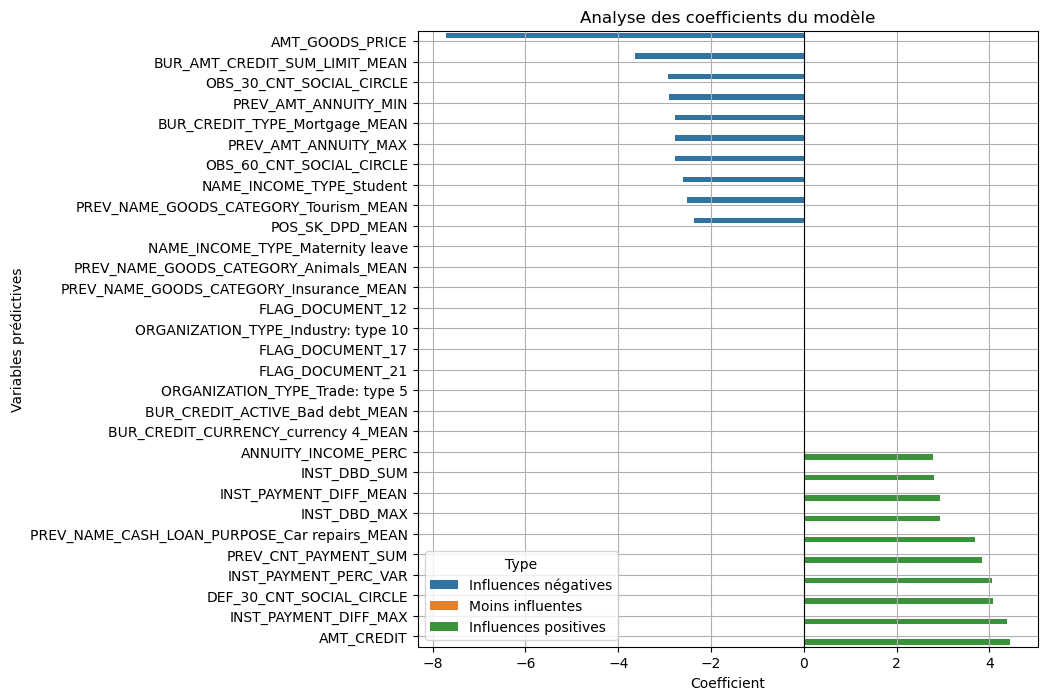

In [35]:
# Indices des coefficients triés par ordre croissant
indices_importance = np.argsort(lr.coef_)

# Réorganisation des noms des variables prédictives et des coefficients
nom_variables = [X_resampled.columns[i] for i in indices_importance[0]]
importance = [lr.coef_[0][i] for i in indices_importance[0]]

# Nombre de coefficients à sélectionner pour les plus et moins influents
n = 10

# Sélection des n coefficients les plus importants (positifs)
top_indices = indices_importance[0][-n:]  # Les n derniers indices (les plus grands)
top_nom_variables = [X_resampled.columns[i] for i in top_indices]
top_importance = [lr.coef_[0][i] for i in top_indices]

# Sélection des n coefficients les moins importants (négatifs)
bottom_indices = indices_importance[0][:n]  # Les n premiers indices (les plus petits)
bottom_nom_variables = [X_resampled.columns[i] for i in bottom_indices]
bottom_importance = [lr.coef_[0][i] for i in bottom_indices]

# Calcul des indices des n coefficients les plus proches de zéro (faible influence)
zero_indices = np.argsort(np.abs(lr.coef_[0]))[:n]
zero_nom_variables = [X_resampled.columns[i] for i in zero_indices]
zero_importance = [lr.coef_[0][i] for i in zero_indices]

# Création de trois DataFrame pour les données des coefficients
df_top = pd.DataFrame({
    'Variables prédictives': top_nom_variables,
    'Coefficient': top_importance,
    'Type': 'Influences positives'
})

df_bottom = pd.DataFrame({
    'Variables prédictives': bottom_nom_variables,
    'Coefficient': bottom_importance,
    'Type': 'Influences négatives'
})

df_zero = pd.DataFrame({
    'Variables prédictives': zero_nom_variables,
    'Coefficient': zero_importance,
    'Type': 'Moins influentes'
})

# Concaténation des trois DataFrame en un seul DataFrame
df_combined = pd.concat([df_bottom, df_zero, df_top])

# Création du graphique en barres horizontal avec Seaborn
plt.figure(figsize=(8, 8))
sns.barplot(x='Coefficient', y='Variables prédictives', data=df_combined, hue='Type')
plt.title('Analyse des coefficients du modèle')
plt.xlabel('Coefficient')
plt.ylabel('Variables prédictives')
plt.grid(True)
plt.axvline(x=0, color='black', linewidth=0.8)
plt.show()

- La variable qui a le plus d'influence négative sur les prédictions du modèle est AMT_GOODS_PRICE qui nous renseigne sur le prix du bien que le client a demandé lors de la demande de crédit précédente.

- Les variables qui ont le plus d'influence positive sur les prédictions du modèle sont :
    - AMT_CREDIT : Montant final du crédit concernant la demande précédente,
    - INST_PAYMENT_DIFF_MAX : Différence entre le montant du crédit prescrit et le montant réellement payé.

### SVM

In [36]:
# Paramètres pour SVM
param_grid_svm = {
    'C': [0.1, 1.0, 10.0]
}

# Test des modèles avec GridSearchCV
svm, svm_training_time = log_model(SVC(kernel="linear", probability=True),
                                    param_grid_svm, 
                                    "svm",
                                    X_train, 
                                    y_train, 
                                    X_test, 
                                    y_test)

svm Score métier: -1.8547467292854747
svm Accuracy: 0.6548138208654813
svm AUC: 0.7134297425754346


Analyse des coefficients du modèle :

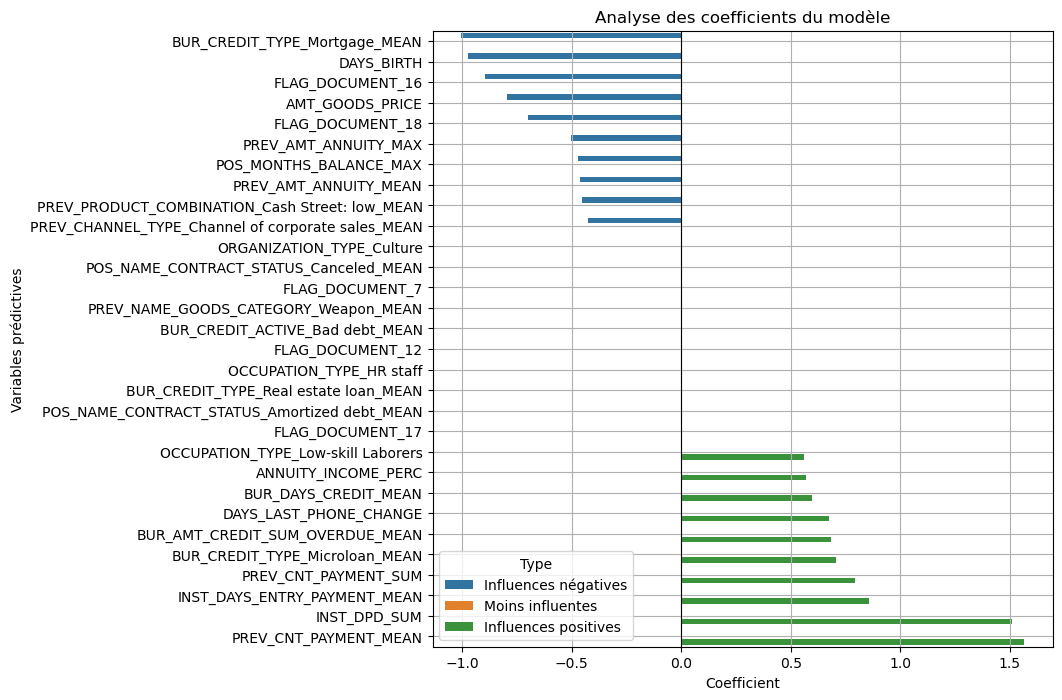

In [37]:
# Indices des coefficients triés par ordre croissant
indices_importance = np.argsort(svm.coef_)

# Réorganisation des noms des variables prédictives et des coefficients
nom_variables = [X_resampled.columns[i] for i in indices_importance[0]]
importance = [svm.coef_[0][i] for i in indices_importance[0]]

# Nombre de coefficients à sélectionner pour les plus et moins influents
n = 10

# Sélection des n coefficients les plus importants (positifs)
top_indices = indices_importance[0][-n:]  # Les n derniers indices (les plus grands)
top_nom_variables = [X_resampled.columns[i] for i in top_indices]
top_importance = [svm.coef_[0][i] for i in top_indices]

# Sélection des n coefficients les moins importants (négatifs)
bottom_indices = indices_importance[0][:n]  # Les n premiers indices (les plus petits)
bottom_nom_variables = [X_resampled.columns[i] for i in bottom_indices]
bottom_importance = [svm.coef_[0][i] for i in bottom_indices]

# Calcul des indices des n coefficients les plus proches de zéro (faible influence)
zero_indices = np.argsort(np.abs(svm.coef_[0]))[:n]
zero_nom_variables = [X_resampled.columns[i] for i in zero_indices]
zero_importance = [svm.coef_[0][i] for i in zero_indices]

# Création de trois DataFrame pour les données des coefficients
df_top = pd.DataFrame({
    'Variables prédictives': top_nom_variables,
    'Coefficient': top_importance,
    'Type': 'Influences positives'
})

df_bottom = pd.DataFrame({
    'Variables prédictives': bottom_nom_variables,
    'Coefficient': bottom_importance,
    'Type': 'Influences négatives'
})

df_zero = pd.DataFrame({
    'Variables prédictives': zero_nom_variables,
    'Coefficient': zero_importance,
    'Type': 'Moins influentes'
})

# Concaténation des trois DataFrame en un seul DataFrame
df_combined = pd.concat([df_bottom, df_zero, df_top])

# Création du graphique en barres horizontal avec Seaborn
plt.figure(figsize=(8, 8))
sns.barplot(x='Coefficient', y='Variables prédictives', data=df_combined, hue='Type')
plt.title('Analyse des coefficients du modèle')
plt.xlabel('Coefficient')
plt.ylabel('Variables prédictives')
plt.grid(True)
plt.axvline(x=0, color='black', linewidth=0.8)
plt.show()

- Les variables qui ont le plus d'influence négative sur les prédictions du modèle sont :
    - BUR_CREDIT_TYPE_Mortgage_MEAN : Type du crédit précédent, spécifiquement pour la classe "Mortgage" (Hypothèque),
    - DAYS_BIRTH : Âge du client.
- Les variables qui ont le plus d'influence positive sur les prédictions du modèle sont :
    - PREV_CNT_PAYMENT_MEAN : Durée moyenne des crédits précédents du client,
    - INST_DPD_SUM : Différence entre la date de paiement réele et la date de paiement prévue du crédit.

### Random Forest

In [38]:
# Paramètres pour Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Test des modèles avec GridSearchCV
rf, rf_training_time = log_model(RandomForestClassifier(), param_grid_rf, "random_forest", X_train, y_train, X_test, y_test)

random_forest Score métier: -1.8591076819859107
random_forest Accuracy: 0.6172425360617243
random_forest AUC: 0.6705684308369068


Analyse de la feature importance du modèle :

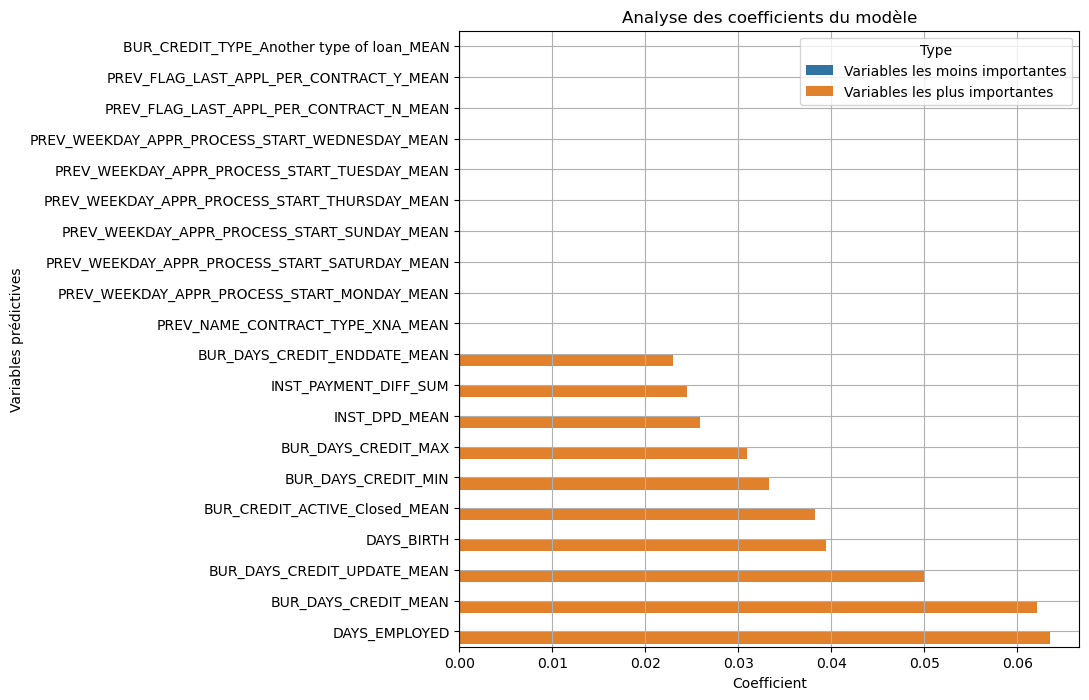

In [39]:
# Indices des coefficients triés par ordre croissant
indices_importance = np.argsort(rf.feature_importances_)
    
# Réorganisation des noms des variables prédictives et des coefficients
nom_variables = [X_resampled.columns[i] for i in indices_importance]
importance = [rf.feature_importances_[i] for i in indices_importance]
    
# Sélection des n coefficients les plus importants (positifs)
top_indices = indices_importance[-n:]  # Les n derniers indices (les plus grands)
top_nom_variables = [X_resampled.columns[i] for i in top_indices]
top_importance = [rf.feature_importances_[i] for i in top_indices]

# Sélection des n coefficients les moins importants
bottom_indices = indices_importance[:n]  # Les n premiers indices (les plus petits)
bottom_nom_variables = [X_resampled.columns[i] for i in bottom_indices]
bottom_importance = [rf.feature_importances_[i] for i in bottom_indices]

# Création de deux DataFrame pour les données
df_top = pd.DataFrame({
    'Variables prédictives': top_nom_variables,
    'Coefficient': top_importance,
    'Type': 'Variables les plus importantes'
})

df_bottom = pd.DataFrame({
    'Variables prédictives': bottom_nom_variables,
    'Coefficient': bottom_importance,
    'Type': 'Variables les moins importantes'
})

# Concaténation des deux DataFrame en un seul DataFrame
df_combined = pd.concat([df_bottom, df_top])

# Création du graphique en barres horizontal avec Seaborn
plt.figure(figsize=(8, 8))
sns.barplot(x='Coefficient', y='Variables prédictives', data=df_combined, hue='Type')
plt.title('Analyse des coefficients du modèle')
plt.xlabel('Coefficient')
plt.ylabel('Variables prédictives')
plt.grid(True)
plt.axvline(x=0, color='black', linewidth=0.8)
plt.show()

Les variables les plus importantes pour la prédiction du modèle sont : 
- BUR_DAYS_CREDIT_MEAN : Nombre de jours avant la demande actuelle où le client a fait une demande de crédit auprès d'autres institutions financières,
- DAYS_BIRTH : Âge du client,
- BUR_DAYS_CREDIT_UPDATE_MEAN : Nombre de jours avant la demande de prêt où la dernière information sur le crédit Credit Bureau a été communiquée.

### XGBoost

In [33]:
# Paramètres pour XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.15]
}

# Test des modèles avec GridSearchCV
xgb, xgb_training_time = log_model(XGBClassifier(), param_grid_xgb, "xgb", X_train, y_train, X_test, y_test)

xgb Score métier: -1.7913451861791345
xgb Accuracy: 0.6638711841663871
xgb AUC: 0.7260478785733521


Setuptools is replacing distutils.


Analyse de la feature importance du modèle :

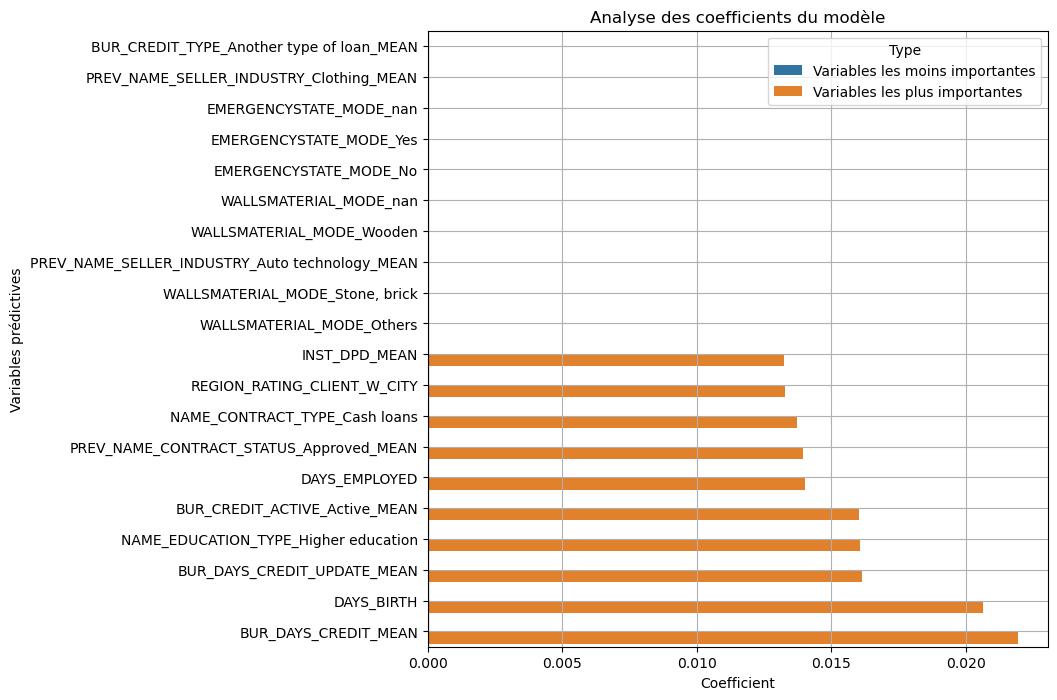

In [41]:
# Indices des coefficients triés par ordre croissant
indices_importance = np.argsort(xgb.feature_importances_)
    
# Réorganisation des noms des variables prédictives et des coefficients
nom_variables = [X_resampled.columns[i] for i in indices_importance]
importance = [xgb.feature_importances_[i] for i in indices_importance]
    
# Sélection des n coefficients les plus importants (positifs)
top_indices = indices_importance[-n:]  # Les n derniers indices (les plus grands)
top_nom_variables = [X_resampled.columns[i] for i in top_indices]
top_importance = [xgb.feature_importances_[i] for i in top_indices]

# Sélection des n coefficients les moins importants
bottom_indices = indices_importance[:n]  # Les n premiers indices (les plus petits)
bottom_nom_variables = [X_resampled.columns[i] for i in bottom_indices]
bottom_importance = [xgb.feature_importances_[i] for i in bottom_indices]

# Création de deux DataFrame pour les données
df_top = pd.DataFrame({
    'Variables prédictives': top_nom_variables,
    'Coefficient': top_importance,
    'Type': 'Variables les plus importantes'
})

df_bottom = pd.DataFrame({
    'Variables prédictives': bottom_nom_variables,
    'Coefficient': bottom_importance,
    'Type': 'Variables les moins importantes'
})

# Concaténation des deux DataFrame en un seul DataFrame
df_combined = pd.concat([df_bottom, df_top])

# Création du graphique en barres horizontal avec Seaborn
plt.figure(figsize=(8, 8))
sns.barplot(x='Coefficient', y='Variables prédictives', data=df_combined, hue='Type')
plt.title('Analyse des coefficients du modèle')
plt.xlabel('Coefficient')
plt.ylabel('Variables prédictives')
plt.grid(True)
plt.axvline(x=0, color='black', linewidth=0.8)
plt.show()

Les variables les plus importantes pour la prédiction du modèle sont :
- BUR_DAYS_CREDIT_MEAN : Nombre de jours avant la demande actuelle où le client a fait une demande de crédit auprès d'autres institutions financières,
- DAYS_BIRTH : Âge du client,
- BUR_DAYS_CREDIT_UPDATE_MEAN : Nombre de jours avant la demande de prêt où la dernière information sur le crédit Credit Bureau a été communiquée.

### Perceptron multicouche (MLP)

In [42]:
# Paramètres pour MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd']
}

# Test des modèles avec GridSearchCV
mlp, mlp_training_time = log_model(MLPClassifier(), param_grid_mlp, "mlp", X_train, y_train, X_test, y_test)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

mlp Score métier: -1.8872861455887286
mlp Accuracy: 0.6524656155652465
mlp AUC: 0.7107731743805769


Analyse de la feature importance du modèle :

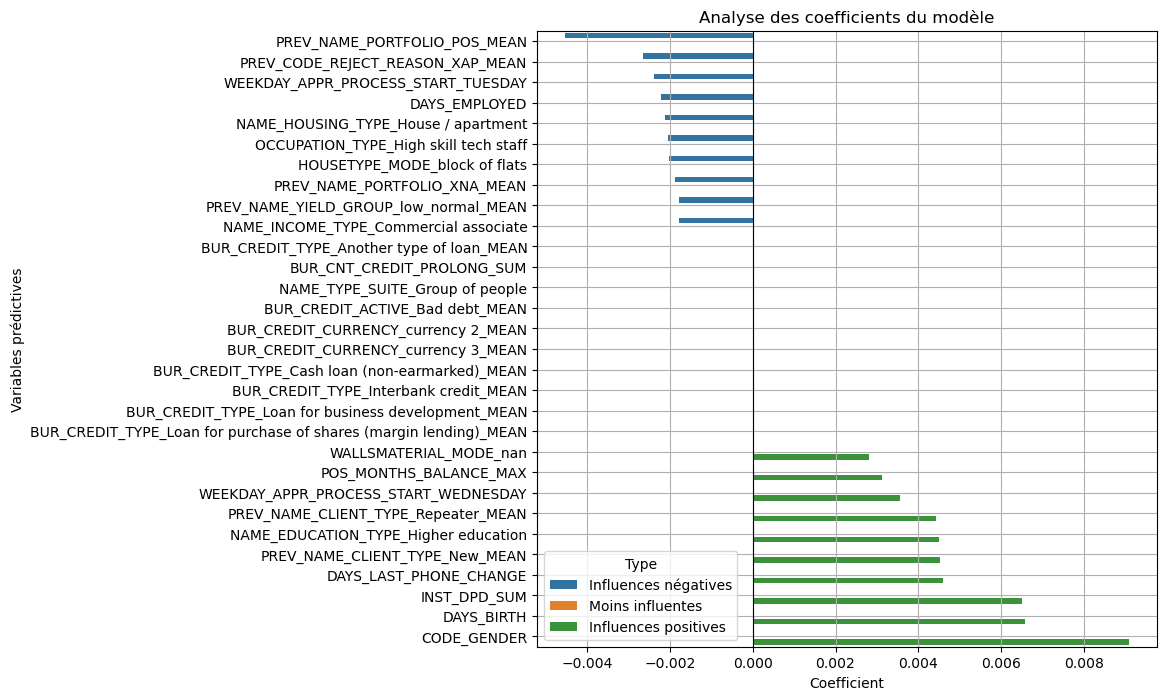

In [43]:
# Calculer l'importance des features par permutation
permut = permutation_importance(mlp, X_test, y_test, n_repeats=10, random_state=42)
indices_importance = np.argsort(permut.importances_mean)

# Réorganisation des noms des variables prédictives et des coefficients
nom_variables = [X_resampled.columns[i] for i in indices_importance]
importance = [permut.importances_mean[i] for i in indices_importance]
    
# Sélection des n coefficients les plus importants
top_indices = indices_importance[-n:]  # Les n derniers indices (les plus grands)
top_nom_variables = [X_resampled.columns[i] for i in top_indices]
top_importance = [permut.importances_mean[i] for i in top_indices]

# Sélection des n coefficients les moins importants
bottom_indices = indices_importance[:n]  # Les n premiers indices (les plus petits)
bottom_nom_variables = [X_resampled.columns[i] for i in bottom_indices]
bottom_importance = [permut.importances_mean[i] for i in bottom_indices]
        
# Calcul des indices des n coefficients les plus proches de zéro (faible influence)
zero_indices = np.argsort(np.abs(permut.importances_mean))[:n]
zero_nom_variables = [X_resampled.columns[i] for i in zero_indices]
zero_importance = [permut.importances_mean[i] for i in zero_indices]

# Création de trois DataFrame pour les données des coefficients
df_top = pd.DataFrame({
    'Variables prédictives': top_nom_variables,
    'Coefficient': top_importance,
    'Type': 'Influences positives'
})

df_bottom = pd.DataFrame({
    'Variables prédictives': bottom_nom_variables,
    'Coefficient': bottom_importance,
    'Type': 'Influences négatives'
})

df_zero = pd.DataFrame({
    'Variables prédictives': zero_nom_variables,
    'Coefficient': zero_importance,
    'Type': 'Moins influentes'
})

# Concaténation des trois DataFrame
df_combined = pd.concat([df_bottom, df_zero, df_top])

# Création du graphique en barres horizontal avec Seaborn
plt.figure(figsize=(8, 8))
sns.barplot(x='Coefficient', y='Variables prédictives', data=df_combined, hue='Type')
plt.title('Analyse des coefficients du modèle')
plt.xlabel('Coefficient')
plt.ylabel('Variables prédictives')
plt.grid(True)
plt.axvline(x=0, color='black', linewidth=0.8)
plt.show()

- La variable qui a le plus d'influence négative sur les prédictions du modèle est EMERGENCYSTATE_MODE_No : Informations  sur le bâtiment dans lequel vit le client.

- La variables qui a le plus d'influence positive sur les prédictions du modèle est INST_DPD_SUM : Différence entre la date de paiement réele et la date de paiement prévue du crédit.

## Evaluation des modèles

Fonction d'évaluation des performances d'un modèle de machine learning :

In [44]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Évalue un modèle de machine learning.

    Parameters:
    - model: le modèle de machine learning déjà entraîné.
    - X_test: les données d'entraînement.
    - y_test: les étiquettes d'entraînement.
    - X_test: les données de test.
    - y_test: les étiquettes de test.

    Returns:
    - metrics: un dictionnaire contenant le score métier, l'accuracy, la précision, le rappel et le roc_auc.
    """
    # Prédictions du modèle
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Probabilités des prédictions
    y_proba_train = model.predict_proba(X_train)[:, 1]
    y_proba_test = model.predict_proba(X_test)[:, 1]

    # Calcul des métriques sur l'ensemble d'entraînement
    business_sc_train = business_score(y_train, y_pred_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    roc_auc_train = roc_auc_score(y_train, y_proba_train)
    
    # Calcul des métriques sur l'ensemble de test
    business_sc_test = business_score(y_test, y_pred_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_proba_test)

    # Retourner les métriques sous forme de dictionnaire
    metrics = {
        'score_métier_train': business_sc_train,
        'accuracy_train': accuracy_train,
        'precision_train': precision_train,
        'recall_train': recall_train,
        'roc_auc_train': roc_auc_train,
        'score_métier_test': business_sc_test,
        'accuracy_test': accuracy_test,
        'precision_test': precision_test,
        'recall_test': recall_test,
        'roc_auc_test': roc_auc_test
    }

    return metrics

Synthèse comparative des performances des modèles testés :

In [45]:
# Liste des modèles à évaluer
models = [dum, lr, svm, rf, xgb, mlp]
# Noms des modèles correspondants
model_names = ['Dummy Classifier', 'Régression Logistique', 'SVM', 'Random Forest', 'XGBoost', 'MLP']

# Initialisation des listes pour stocker les scores et métriques pour l'ensemble d'entraînement
scores_train = []
accuracies_train = []
precisions_train = []
recalls_train = []
roc_aucs_train = []

# Initialisation des listes pour stocker les scores et métriques pour l'ensemble de test
scores_test = []
accuracies_test = []
precisions_test = []
recalls_test = []
roc_aucs_test = []

# Boucle sur chaque modèle pour évaluation
for model in models:
    # Évaluation du modèle avec la fonction evaluate_model
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    
    # Stockage des métriques pour l'ensemble d'entraînement
    scores_train.append(metrics['score_métier_train'])
    accuracies_train.append(metrics['accuracy_train'])
    precisions_train.append(metrics['precision_train'])
    recalls_train.append(metrics['recall_train'])
    roc_aucs_train.append(metrics['roc_auc_train'])
    
    # Stockage des métriques pour l'ensemble de test
    scores_test.append(metrics['score_métier_test'])
    accuracies_test.append(metrics['accuracy_test'])
    precisions_test.append(metrics['precision_test'])
    recalls_test.append(metrics['recall_test'])
    roc_aucs_test.append(metrics['roc_auc_test'])

# Création d'un dictionnaire pour stocker toutes les métriques
df_metrics = {
    'Modèle': model_names,  # Noms des modèles

    # Métriques pour l'ensemble d'entraînement
    'Score Métier (Entraînement)': scores_train,
    'Accuracy (Entraînement)': accuracies_train,
    'Précision (Entraînement)': precisions_train,
    'Rappel (Entraînement)': recalls_train,
    'ROC AUC (Entraînement)': roc_aucs_train,

    # Métriques pour l'ensemble de test
    'Score Métier (Test)': scores_test,
    'Accuracy (Test)': accuracies_test,
    'Précision (Test)': precisions_test,
    'Rappel (Test)': recalls_test,
    'ROC AUC (Test)': roc_aucs_test,

    # Temps d'entraînement pour chaque modèle
    "Temps d'entraînement" : [dum_training_time, lr_training_time, svm_training_time, 
                              rf_training_time, xgb_training_time, mlp_training_time]
}

# Conversion du dictionnaire en DataFrame pandas pour une présentation et analyse faciles
df_metrics = pd.DataFrame(df_metrics)
df_metrics  # Affichage du DataFrame contenant toutes les métriques pour chaque modèle

,Modèle,Score Métier (Entraînement),Accuracy (Entraînement),Précision (Entraînement),Rappel (Entraînement),ROC AUC (Entraînement),Score Métier (Test),Accuracy (Test),Précision (Test),Rappel (Test),ROC AUC (Test),Temps d'entraînement
0,Dummy Classifier,-0.496365,0.503635,0.503635,1.000000,0.500000,-0.510902,0.489098,0.489098,1.000000,0.500000,0.037582
1,Régression Logistique,-1.603959,0.702606,0.701927,0.711748,0.772140,-1.800738,0.654478,0.640420,0.669410,0.712443,1.741917
2,SVM,-1.670954,0.690974,0.690789,0.699534,0.755696,-1.854747,0.654814,0.644250,0.657064,0.713430,82.978391
3,Random Forest,-1.663796,0.661895,0.651267,0.707528,0.722727,-1.859108,0.617243,0.597779,0.664609,0.670568,1.111929
4,XGBoost,-1.276255,0.768594,0.770685,0.769487,0.847048,-1.791345,0.663871,0.652406,0.669410,0.726048,1.448526
5,MLP,-1.729896,0.686389,0.689072,0.687542,0.744669,-1.887286,0.652466,0.643148,0.650206,0.710773,29.312647


Affichage sous forme de graphique :

Comparaison des scores de prédiction des modèles :


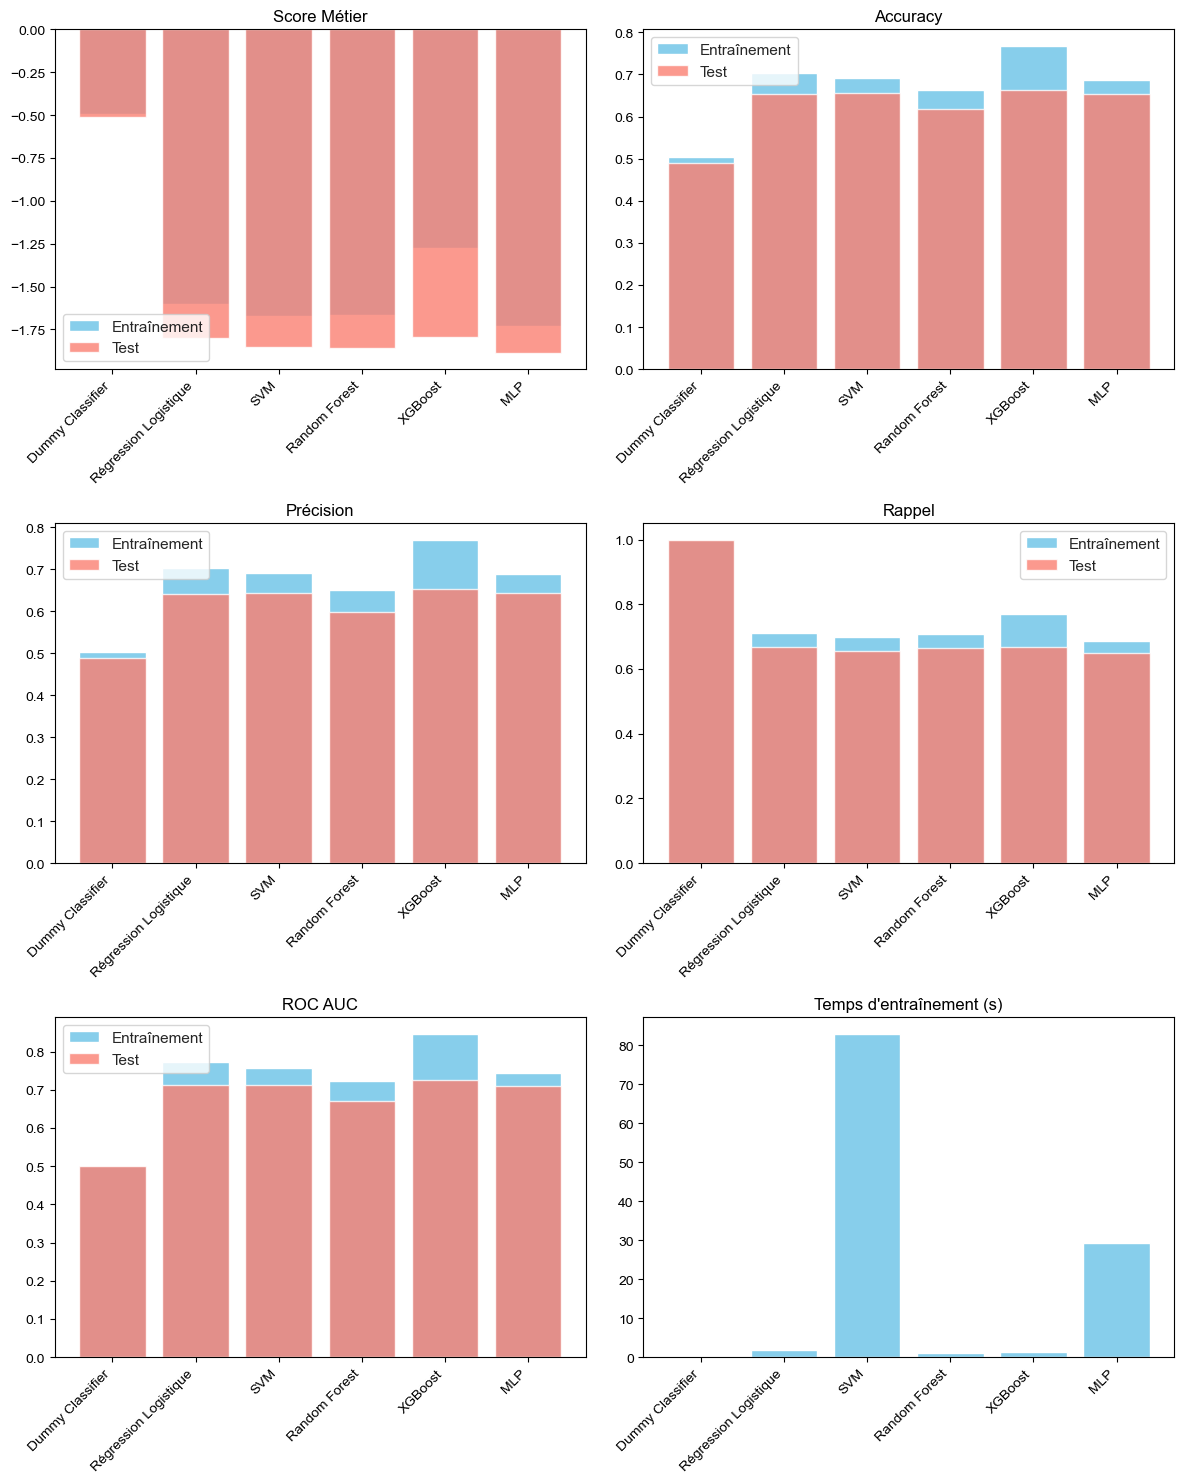

In [46]:
print("Comparaison des scores de prédiction des modèles :")
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
sns.set(style="whitegrid")

# Scoré métier
axs[0, 0].bar(df_metrics['Modèle'], df_metrics['Score Métier (Entraînement)'], label='Entraînement', color='skyblue')
axs[0, 0].bar(df_metrics['Modèle'], df_metrics['Score Métier (Test)'], label='Test', color='salmon', alpha=0.8)
axs[0, 0].set_title('Score Métier')
axs[0, 0].legend()
axs[0, 0].set_xticks(range(len(df_metrics['Modèle'])))
axs[0, 0].set_xticklabels(df_metrics['Modèle'], rotation=45, ha='right')

# Accuracy
axs[0, 1].bar(df_metrics['Modèle'], df_metrics['Accuracy (Entraînement)'], label='Entraînement', color='skyblue')
axs[0, 1].bar(df_metrics['Modèle'], df_metrics['Accuracy (Test)'], label='Test', color='salmon', alpha=0.8)
axs[0, 1].set_title('Accuracy')
axs[0, 1].legend()
axs[0, 1].set_xticks(range(len(df_metrics['Modèle'])))
axs[0, 1].set_xticklabels(df_metrics['Modèle'], rotation=45, ha='right')

# Précision
axs[1, 0].bar(df_metrics['Modèle'], df_metrics['Précision (Entraînement)'], label='Entraînement', color='skyblue')
axs[1, 0].bar(df_metrics['Modèle'], df_metrics['Précision (Test)'], label='Test', color='salmon', alpha=0.8)
axs[1, 0].set_title('Précision')
axs[1, 0].legend()
axs[1, 0].set_xticks(range(len(df_metrics['Modèle'])))
axs[1, 0].set_xticklabels(df_metrics['Modèle'], rotation=45, ha='right')

# Rappel
axs[1, 1].bar(df_metrics['Modèle'], df_metrics['Rappel (Entraînement)'], label='Entraînement', color='skyblue')
axs[1, 1].bar(df_metrics['Modèle'], df_metrics['Rappel (Test)'], label='Test', color='salmon', alpha=0.8)
axs[1, 1].set_title('Rappel')
axs[1, 1].legend()
axs[1, 1].set_xticks(range(len(df_metrics['Modèle'])))
axs[1, 1].set_xticklabels(df_metrics['Modèle'], rotation=45, ha='right')

# ROC AUC
axs[2, 0].bar(df_metrics['Modèle'], df_metrics['ROC AUC (Entraînement)'], label='Entraînement', color='skyblue')
axs[2, 0].bar(df_metrics['Modèle'], df_metrics['ROC AUC (Test)'], label='Test', color='salmon', alpha=0.8)
axs[2, 0].set_title('ROC AUC')
axs[2, 0].legend()
axs[2, 0].set_xticks(range(len(df_metrics['Modèle'])))
axs[2, 0].set_xticklabels(df_metrics['Modèle'], rotation=45, ha='right')

# Temps d'entraînement
axs[2, 1].bar(df_metrics['Modèle'], df_metrics["Temps d'entraînement"], color='skyblue')
axs[2, 1].set_title("Temps d'entraînement (s)")
axs[2, 1].set_xticks(range(len(df_metrics['Modèle'])))
axs[2, 1].set_xticklabels(df_metrics['Modèle'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

Le meilleur score métier sur le jeu de données de test a été obtenu avec le modèle Dummy Classifier. Cependant, ce modèle prédit systématiquement que tous les clients ne remboursent pas leur prêt (classe 1). Ce modèle est inefficace car il ne parvient jamais à identifier les clients qui remboursent leur crédit. Par conséquent, il n'est pas adapté pour résoudre le problème.

Le modèle XGBoost permet d'obtenir les meilleurs performances pour les métriques score métier, accuracy, precision, rappel et roc-auc sur le jeu de données de test.

A noter que les scores roc-auc sur le jeu de données de test de l'ensemble des modèles ne sont pas supérieurs au meilleur score de la compétition Kaggle sur le même jeu de données (à savoir 0.82).

Enfin, le temps de calcul des modèles de SVP et MLP sont considérablement plus importants que les autres.

Etant donné ces éléments, nous allons sélectionner le modèle XGBoost comme modèle final, en affinant ses hyperparamètres pour essayer d'améliorer davantage ses performances.

## Amélioration des hyperparamètres du modèle final 

Les hyperparamètres du modèle XGBoost obtenus avec la procédure de validation croisée sont :
- 'n_estimators'= 100, 
- 'max_depth' = 3,
- 'learning_rate' = 0.15.

Nous allons tenter de les optimiser davantage :

In [47]:
# Définir les paramètres à tester
param_grid = {
    'n_estimators': [80, 90, 100, 110, 120],
    'learning_rate': [0.13, 0.14, 0.15, 0.16, 0.17]
}

# Initialiser GridSearchCV
grid_search = GridSearchCV(XGBClassifier(max_depth=3), param_grid, cv=5, scoring=custom_scorer)

# Entraîner le modèle
grid_search.fit(X_train, y_train)

# Meilleurs paramètres trouvés
best_params = grid_search.best_params_
print(f"Meilleurs paramètres : {best_params}")

Meilleurs paramètres : {'learning_rate': 0.16, 'n_estimators': 90}


Comparaison des scores de performance du modèle avec les anciens et les nouveaux hyperparamètres :

In [48]:
# Évaluation sur l'ensemble de test
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Score métier
business_sc = business_score(y_test, predictions)
        
# Accuracy
accuracy = accuracy_score(y_test, predictions)

# ROC AUC
auc_score = roc_auc_score(y_test, y_pred_proba)

# Affichage des métriques
metrics_table = [
    ["Score métier", df_metrics[df_metrics['Modèle'] == 'XGBoost']['Score Métier (Test)'].values, business_sc],
    ["Accuracy", df_metrics[df_metrics['Modèle'] == 'XGBoost']['Accuracy (Test)'], accuracy],
    ["ROC AUC", df_metrics[df_metrics['Modèle'] == 'XGBoost']['ROC AUC (Test)'], auc_score]
]
headers = ["Métrique", "Ancien modèle", "Nouveau modèle"]
print(tabulate(metrics_table, headers=headers, floatfmt=".4f", tablefmt='fancy_grid'))

╒══════════════╤═════════════════╤══════════════════╕
│ Métrique     │   Ancien modèle │   Nouveau modèle │
╞══════════════╪═════════════════╪══════════════════╡
│ Score métier │         -1.7913 │          -1.8011 │
├──────────────┼─────────────────┼──────────────────┤
│ Accuracy     │          0.6639 │           0.6632 │
├──────────────┼─────────────────┼──────────────────┤
│ ROC AUC      │          0.7260 │           0.7280 │
╘══════════════╧═════════════════╧══════════════════╛


Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


Les nouveaux hyperparamètres ne permettent pas d'améliorer les performances du modèle, nous allons donc conserver l'ancien.

## Analyse de la feature importance

### Analyse globale

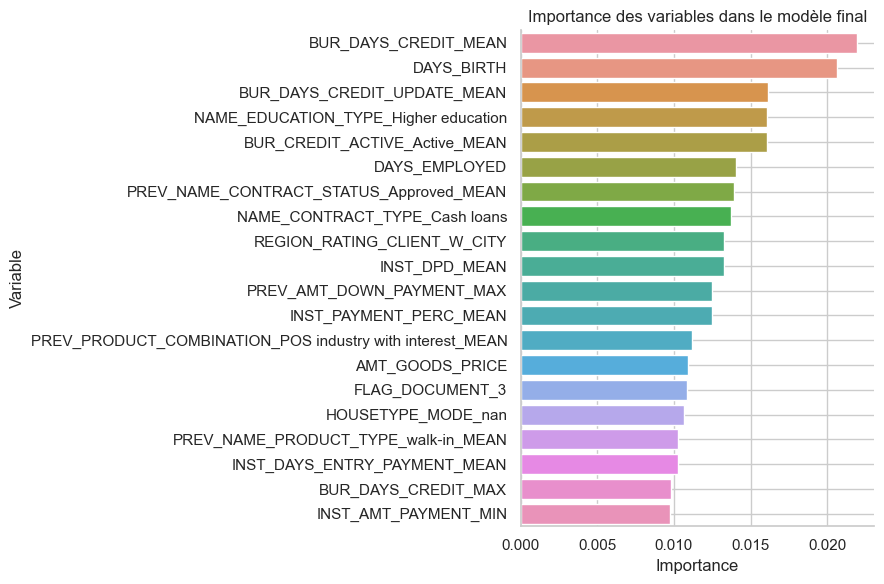

In [50]:
# Création d'un dataframe df_plot
df_plot = pd.DataFrame()
df_plot['feature'] = X_resampled.columns
df_plot['importance'] = xgb.feature_importances_

# Tri par ordre décroissant en fonction de l'importance des variables
df_plot.sort_values(by = 'importance', ascending = False, inplace = True)

# Création d'une figure
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1, 1, 1)
sns.barplot(data = df_plot.head(20), y='feature', x='importance')
ax.set_title('Importance des variables dans le modèle final')
ax.set_ylabel('Variable')
ax.set_xlabel('Importance')
ax.grid(True, which = 'both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

Les variables 'EXT_SOURCE_2' et 'EXT_SOURCE_3' jouent un rôle très important dans la prédiction du modèle. Selon la documentation, ces variables représentent un « score normalisé provenant d'une source de données externe ». Je ne sais pas exactement ce que cela signifie, mais il pourrait s'agir d'une sorte d'évaluation d'accord de crédit réalisée à l'aide de nombreuses sources de données provenant d'autres établissement financiers. Il faudrait se renseigner davantage pour être en mesure d'expliquer de manière transparente pourquoi la demande de crédit a été accordée ou refusée.

On retrouve ensuite la variable PREV_NAME_CONTRACT_STATUS_Refused_MEANS qui nous renseigne sur le statut du contrat du crédit précédent demandé par le client, spécifiquement pour la classes "Refused", à savoir lorsque la demande de prêt précédente a été refusée. Il semble cohérent de constater un lien entre cette variable et la capacité du client à rembourser un prêt.

Enfin, on peut observer d'autres variables qui jouent un rôle important dans la prédiction du modèle qui nous renseignent sur différentes informations pertinentes comme le niveau d'étude du client, la raison pour laquelle le prêt précédent a été refusé, le montant du crédit précédent du client, l'âge du client, le prix du bien pour lequel le client a demandé précédemment un crédit...

### Analyse locale

In [34]:
# Initialisation de Explainer de SHAP avec le modèle entraîné
explainer = shap.Explainer(xgb, X_train)

# Calculer les valeurs SHAP pour l'ensemble de test
shap_values = explainer(X_test)

Représentation graphique de la feature importance locale avec shap.summary_plot :

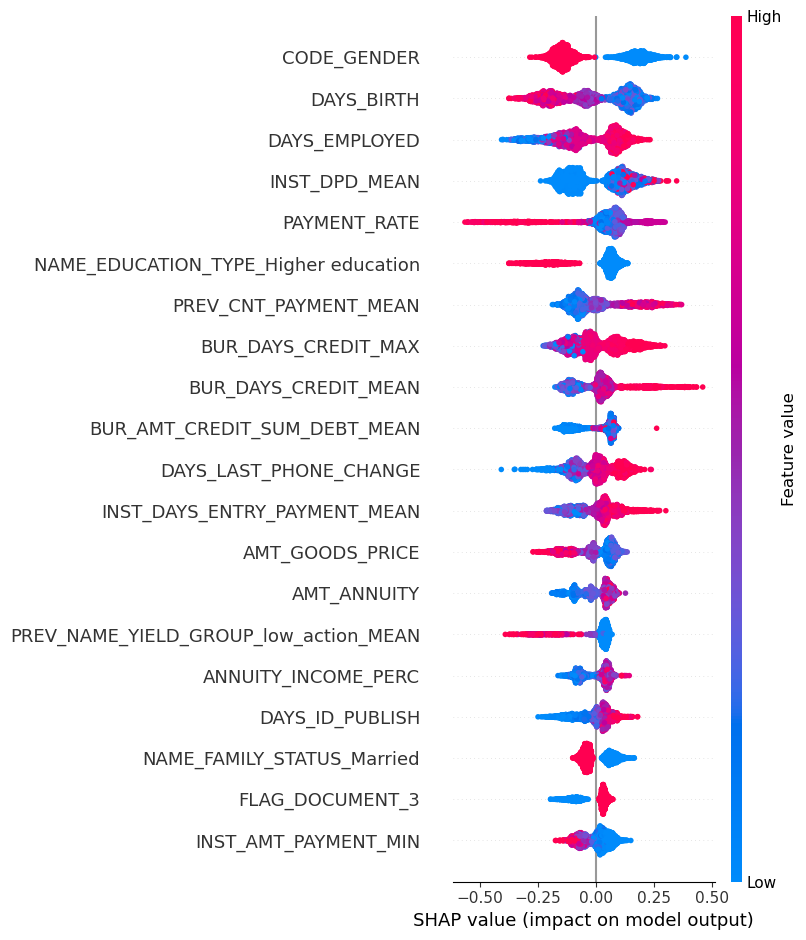

In [35]:
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns)

Visualisation de la feature importance locale pour toutes les prédictions :

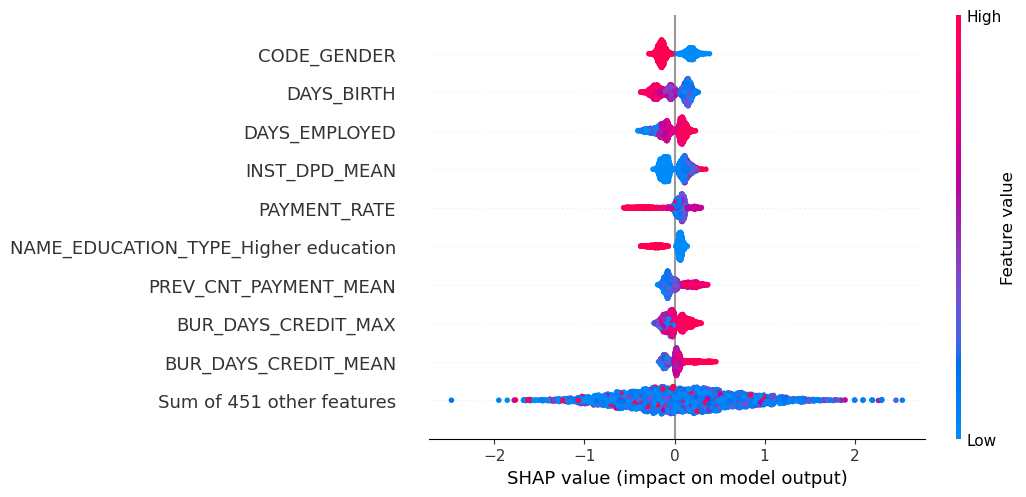

In [36]:
shap.plots.beeswarm(shap_values)

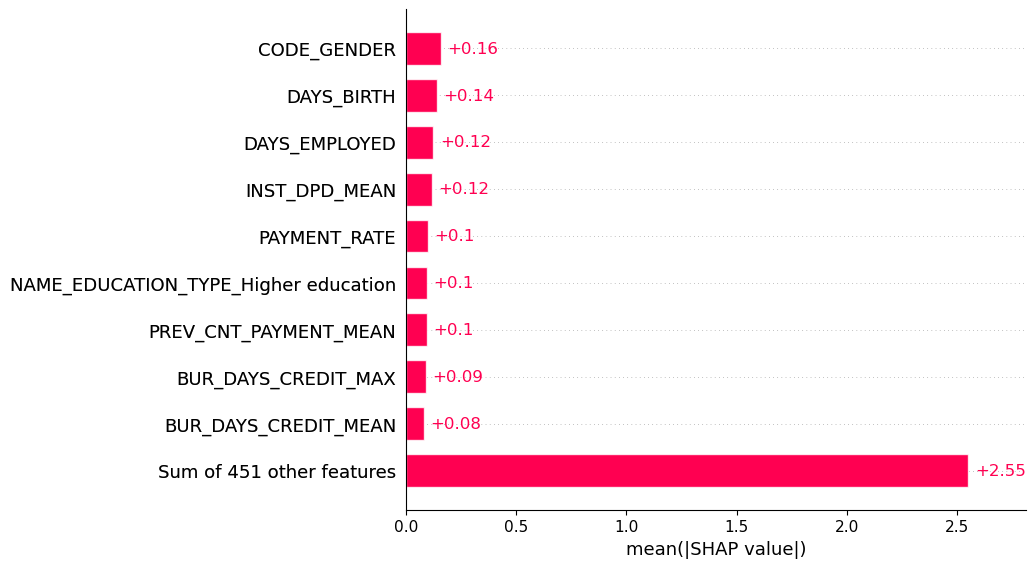

In [37]:
shap.plots.bar(shap_values)

Les caractéristiques les plus importantes dans notre modèle sont CODE_GENDER, DAYS_BIRTH, et DAYS_EMPLOYED. Ce sont celles qui influencent le plus les prédictions du modèle.

**CODE_GENDER**

Pour CODE_GENDER :

- Valeur de 0 : indique un client de genre masculin.
- Valeur de 1 : indique un client de genre féminin.

En observant le shap.summary_plot, nous remarquons que les clients masculins (valeur 0) ont des valeurs SHAP positives, ce qui signifie que le fait qu'un client soit un homme augmente la probabilité que le prêt ne soit pas remboursé à temps (classe 1). Inversement, les clientes féminines (valeur 1) ont des valeurs SHAP négatives, indiquant que le fait qu'un client soit une femme augmente la probabilité que le prêt soit remboursé à temps (classe 0).

**DAYS_BIRTH**

Pour DAYS_BIRTH (âge du client en jours) :

- Les valeurs élevées de DAYS_BIRTH (clients plus âgés) se situent majoritairement sur la gauche du plot (valeurs SHAP négatives).
- Les valeurs faibles de DAYS_BIRTH (clients plus jeunes) se situent principalement sur la droite du plot (valeurs SHAP positives).

Cela signifie que l'âge du client a une influence significative sur la probabilité de remboursement du prêt : plus le client est jeune, plus la probabilité que le prêt ne soit pas remboursé à temps augmente (classe 1). En revanche, plus le client est âgé, plus la probabilité que le prêt soit remboursé à temps augmente (classe 0).

**DAYS_EMPLOYED**

Pour DAYS_EMPLOYED (nombre de jours depuis que le client a commencé son emploi actuel) :

- Les valeurs faibles de DAYS_EMPLOYED (client ayant commencé son emploi récemment) ont des valeurs SHAP négatives, ce qui signifie que le modèle prédit une plus grande probabilité que le prêt soit remboursé à temps (classe 0).
- À l'inverse, les valeurs élevées de DAYS_EMPLOYED (client employé depuis longtemps) tendent à avoir des valeurs SHAP positives, ce qui augmente la probabilité que le prêt ne soit pas remboursé à temps (classe 1).

En résumé, le modèle montre que les hommes et les jeunes clients ont une probabilité plus élevée de ne pas rembourser leur prêt à temps, tandis que les femmes, les clients plus âgés et ceux ayant commencé récemment un nouvel emploi sont plus susceptibles de rembourser leur prêt à temps.

Visualisation des valeurs SHAP pour une prédiction spécifique d'un client ayant remboursé sont prêt :

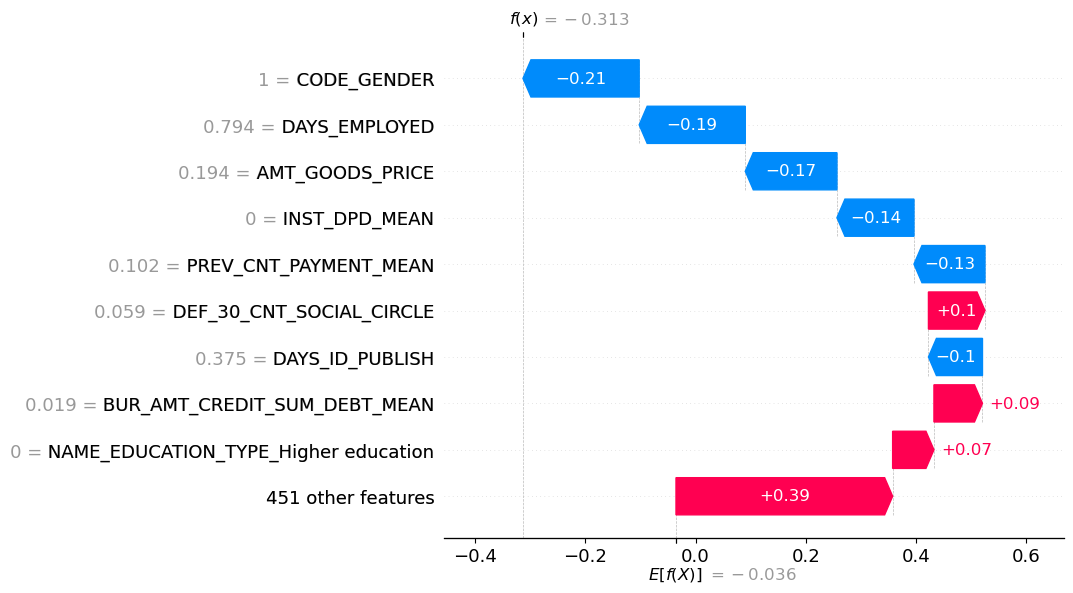

In [38]:
shap.plots.waterfall(shap_values[0])

In [39]:
shap.initjs()
shap.plots.force(shap_values[0])

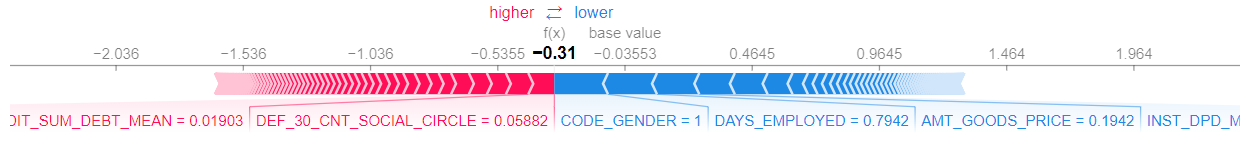

On peut observer pour ce client que la valeur de sortie du modèle est de -0.31, et la valeur de base est de -0.04 (la valeur de base correspond à la moyenne de l'ensemble des données d'entraînement). Ce qui veut dire que le modèle prédit que ce client est en capacité de rembourser son prêt dans les temps.

Les variables qui contribuent le plus à la prédiction du modèle pour ce client sont CODE_GENDER, DAYS_EMPLOYED, AMT_GOODS_PRICE, INST_DPD_MEAN et PREV_CNT_PAYMENT_MEAN. Ces cinq variables ont participé à diminuer la valeur de sortie du modèle, comme l'indique la couleur bleue.

Visualisation des valeurs SHAP pour une prédiction spécifique d'un client n'ayant pas remboursé sont prêt :

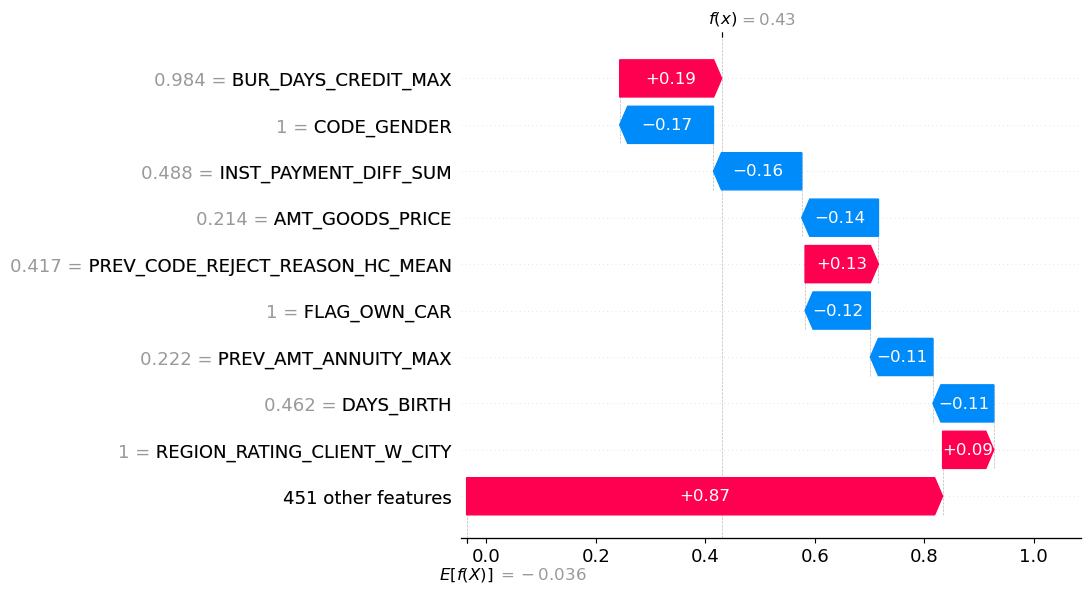

In [40]:
shap.plots.waterfall(shap_values[6])

In [41]:
shap.plots.force(shap_values[6])

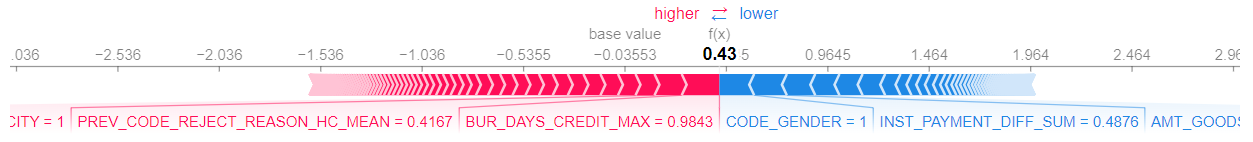

On peut observer pour ce client que la valeur de sortie du modèle est de 0.43, ce qui veut dire que le modèle prédit que ce client n'est pas en capacité de rembourser son prêt dans les temps.

Les variables qui contribuent le plus à cette prédiction sont BUR_DAYS_CREDIT_MAX, CODE_GENDER, INST_PAYMENT_DIFF_SUM, AMT_GOODS_PRICE, PREV_CODE_REJECT_REASON_HC_MEAN, FLAG_OWN_CAR, PREV_AMT_ANNUITY_MAX, DAYS_BIRTH, et REGION_RATING_CLIENT_W_CITY. Parmi elles, les trois qui ont le plus augmenté la valeur de sortie du modèle sont :

- BUR_DAYS_CREDIT_MAX : Nombre maximal de jours avant la demande actuelle où le client a fait une demande de crédit auprès d'autres institutions financières.
- PREV_CODE_REJECT_REASON_HC_MEAN : La raison moyenne pour laquelle les précédentes demandes de crédit ont été rejetées, spécifiquement pour la classe "HC" (probablement une abréviation de "Historical Credit").
- REGION_RATING_CLIENT_W_CITY : La note attribuée par Home Credit à la région où vit le client.

Examinons cela plus en détail :

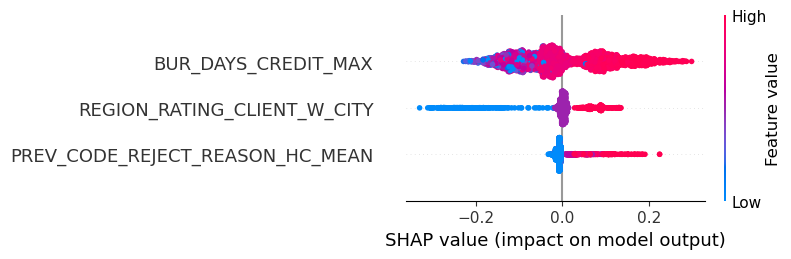

In [46]:
# Liste des variables à afficher
var = ['BUR_DAYS_CREDIT_MAX', 'PREV_CODE_REJECT_REASON_HC_MEAN', 'REGION_RATING_CLIENT_W_CITY']

# Filtrer X_test pour ne garder que les variables spécifiées
X_test_filtered = X_test[var]

# Filtrer les shap_values pour ne garder que les valeurs correspondantes aux variables spécifiées
shap_values_filtered = shap_values[:, [X_test.columns.get_loc(c) for c in var]]

# Afficher le graphique SHAP
shap.summary_plot(shap_values_filtered, X_test_filtered, feature_names=var)

BUR_DAYS_CREDIT_MAX

Le modèle indique que la prédiction que ce client ne remboursera pas son prêt à temps est influencée de manière significative par le fait que la demande de crédit la plus ancienne auprès d'autres institutions financières remonte à un grand nombre de jours. Un nombre élevé de jours depuis la demande de crédit la plus ancienne est un indicateur que le client a des difficultés financières persistantes.

PREV_CODE_REJECT_REASON_HC_MEAN

Le client a un eu au moins un crédit refusé par le passé, en particulier pour des raisons liées à son historique de crédit, ce qui suggère des problèmes financiers passés qui augmentent le risque de non-remboursement.

REGION_RATING_CLIENT_W_CITY

La région où vit le client est considérée comme risquée par Home Credit. Une note régionale élevée suggère que les clients de cette région sont généralement moins susceptibles de rembourser leurs prêts à temps, ce qui influence négativement la prédiction pour ce client.